In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
from pytz import timezone

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show, plot_events_data
from utils.optimization import MyOptimizationProblem, convert_to_model_params, plot_optimization_params, plot_optimization_error, plot_compare, compute_metrics, estimate_polynomial_coefficient_bounds
from utils.data import get_events, get_sections, process_df, export_dataframe_to_latex, load_df as load_df_inner
from utils.sensitivity_analysis import describe_param_with_uniform_distribution, describe_param_with_log_uniform_distribution, describe_param_with_triangular_distribution, describe_param_with_normal_distribution, describe_param_with_truncated_normal_distribution, describe_param_with_log_normal_distribution, wrapped_model_function, create_problem_spec_and_sample, plot_sampled_distribuitions, evaluate_problem, analyze_time_step, analyze_problem, sobol_sensitivity_analysis_from_model_params_to_outputs, plot_sensitivity_analysis, plot_sensitivity_analysis_heatmaps, get_region_mean, plot_sensitivity_analysis_bars

import warnings
warnings.filterwarnings("ignore")

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/'
latex_tex_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/tex/'

# Data

In [2]:
def compute_df_soc(df, nominal_Q_Ah, inplace=False):
    """
    Compute the State of Charge (SOC) of a battery.

    Parameters:
        df (pd.DataFrame): DataFrame containing battery data.
        nominal_Q (float): Nominal capacity of the battery in Ampere-hours (Ah).
        inplace (bool, optional): If True, the SOC values are added to the input DataFrame `df`.
                                  Default is False.

    Returns:
        np.ndarray: Array containing the computed SOC values as a fraction of the nominal capacity.

    Notes:
        - The input DataFrame `df` is expected to contain a column named 'batt_Q' representing the battery charge.
        - The output SOC values are dimensionless fractions representing the battery's charge level relative to its nominal capacity.
        - If `inplace` is True, the computed SOC values are added as a new column 'batt_z' to the input DataFrame `df`.
    """
    SOC = df['batt_Q'].to_numpy() / nominal_Q_Ah

    if inplace:
        df['batt_z'] = SOC
    return SOC

def compute_df_capacity(df, nominal_Q_Ah, initial_SOC, inplace=False):
    """
    Compute the capacity of a battery based on cumulative integration of current over time.

    Parameters:
        df (pd.DataFrame): DataFrame containing battery data.
        nominal_Q (float): Nominal capacity of the battery in Ampere-hours (Ah).
        initial_SOC (float): Initial State of Charge (SOC) as a fraction of the nominal capacity.
        inplace (bool, optional): If True, the computed capacity values are added to the input DataFrame `df`.
                                  Default is False.

    Returns:
        np.ndarray: Array containing the computed capacity values in Ampere-hours (Ah).

    Notes:
        - The input DataFrame `df` is expected to contain columns 'batt_i' for battery current and 't' for time.
        - The output capacity values represent the remaining battery capacity after cumulative integration of current over time.
        - The input parameter `initial_SOC` is a dimensionless fraction representing the initial battery charge relative to its nominal capacity.
        - If `inplace` is True, the computed capacity values are added as a new column 'batt_Q' to the input DataFrame `df`.
    """
    from scipy.integrate import cumulative_trapezoid as cumtrapz

    time_hours = df['t'] / 3600.0  # Converts time in seconds to time in hours
    Q = (nominal_Q_Ah * initial_SOC) - cumtrapz(df['batt_i'], time_hours, initial=0)  # units: Amper-hour

    if inplace:
        df['batt_Q'] = Q
    return Q

def load_df(filename, start, end, resample_rule, rename_columns, print_columns, iqr_threshold, cutoff_freq, sampling_rate, order, nominal_Q_Ah, initial_SOC):
    df = load_df_inner(
        filename=filename,
        start=start,
        end=end,
        resample_rule=resample_rule,
        rename_columns=rename_columns,
        print_columns=print_columns,
        iqr_threshold=iqr_threshold,
        cutoff_freq=cutoff_freq,
        sampling_rate=sampling_rate,
        order=order,
    )

    compute_df_capacity(df, nominal_Q_Ah, initial_SOC, inplace=True)
    compute_df_soc(df, nominal_Q_Ah, inplace=True)

    return df

cell_amps_hour = 48
series_cells = 3
parallel_cells = 1
cell_voltage = 12
nominal_Q = parallel_cells * cell_amps_hour  # Capacity, in Amper-hour
initial_SOC = 1

Train size ≃ 65.92%
Test  size ≃ 34.08%


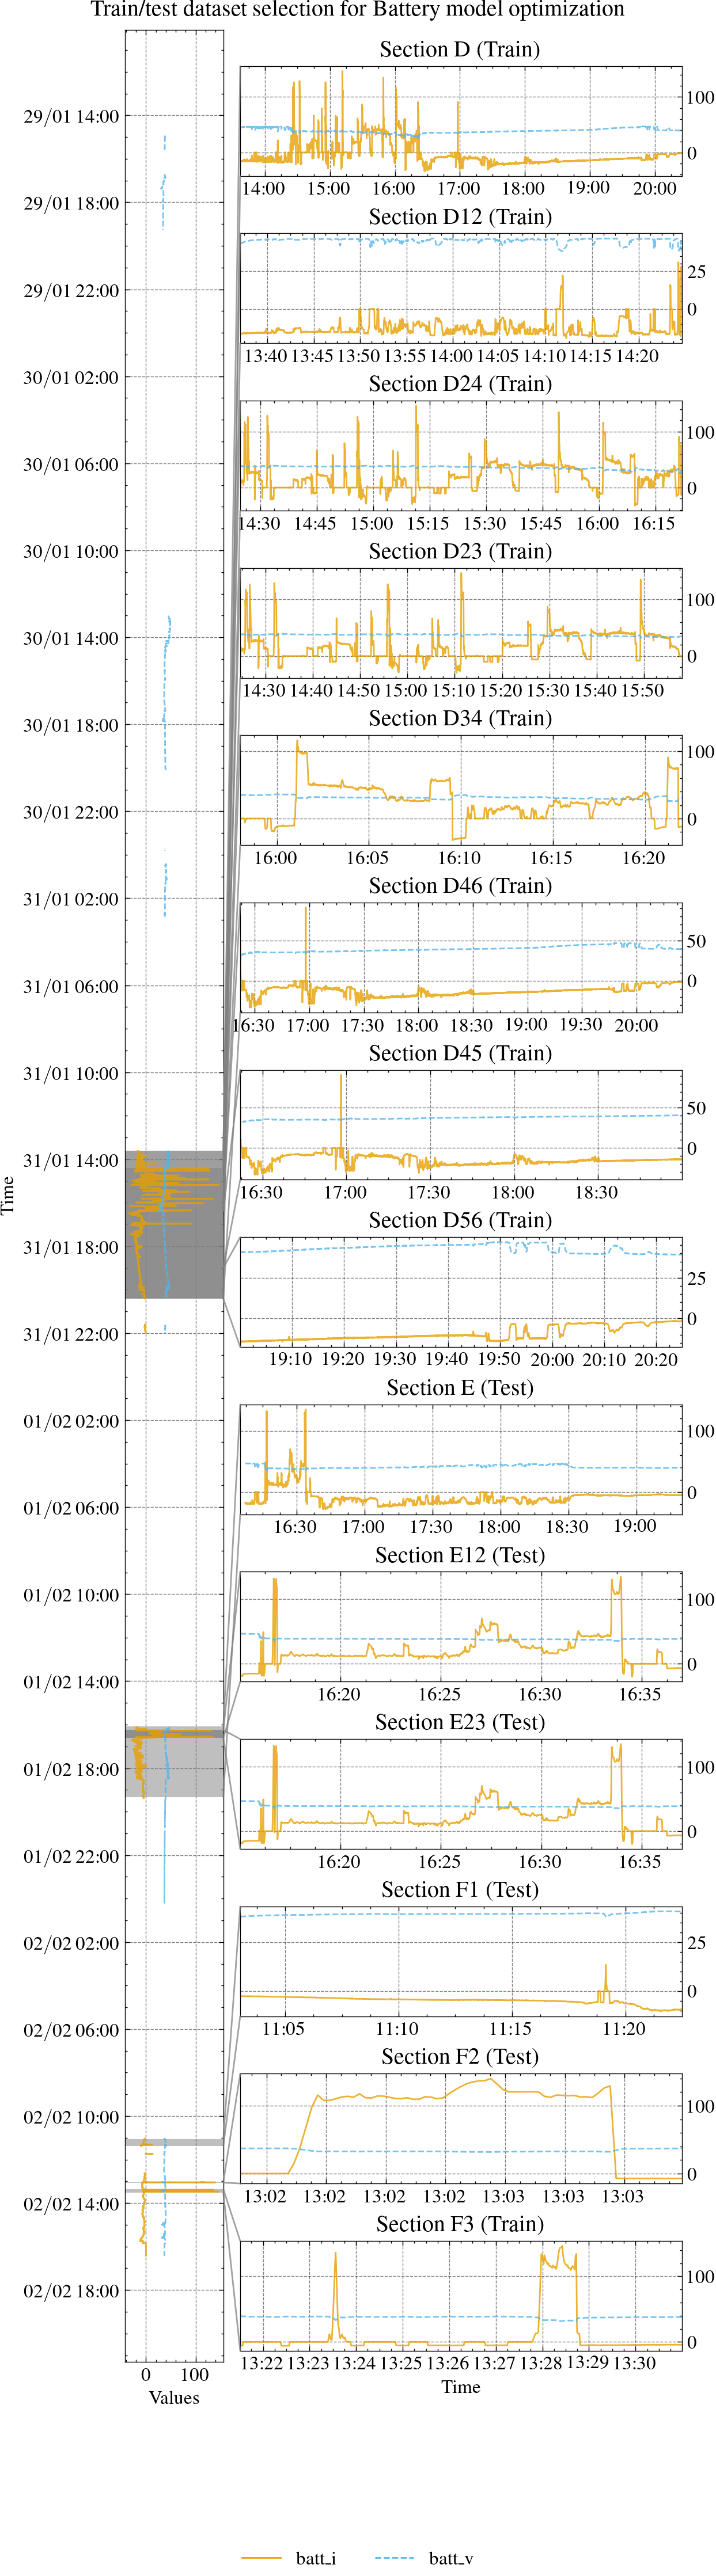

In [3]:
# filename = "../../../models/2020/boat_data_100ms.csv"
filename = "../../../models/2020/boat_data_1s.csv"
rename_columns = {
    'Battery Pack Voltage': 'batt_v',
    'Battery Current': 'batt_i',
}
df = load_df(
    filename=filename,
    start=None,
    end=None,
    resample_rule=None,
    rename_columns=rename_columns,
    print_columns=False,
    iqr_threshold=None,
    cutoff_freq=None,
    sampling_rate=1,
    order=1,
    nominal_Q_Ah=nominal_Q,
    initial_SOC=initial_SOC
)

sections, tzinfo = get_sections()

# Customizing ranges:
D1 = pd.Timestamp('2020-01-31 13:37:04')  # Pre-race charging starts, it starts with the battery almost (if not) fully charged, definitely overcharging it by the start of the race
D2 = pd.Timestamp('2020-01-31 14:24:40')  # start of the race
D3 = pd.Timestamp('2020-01-31 15:58:00')  # battery enters in deep-discharge
D4 = pd.Timestamp('2020-01-31 16:22:00')  # race finishes, post-race charge starts
D5 = pd.Timestamp('2020-01-31 19:00:00')  # overcharge starts
D6 = pd.Timestamp('2020-01-31 20:24:55')  # end of the day
sections.loc['Section D'] = [D1, D6]  # Full race event
sections.loc['Section D12'] = [D1, D2]  # Full pre-race charge
sections.loc['Section D24'] = [D2, D4]  # Full race discharge
sections.loc['Section D23'] = [D2, D3]  # Race normal discharge range
sections.loc['Section D34'] = [D3, D4]  # Race deep-discharge range
sections.loc['Section D46'] = [D4, D6]  # Full post-race charge
sections.loc['Section D45'] = [D4, D5]  # Post-race charge, only the normal charge part
sections.loc['Section D56'] = [D5, D6]  # Post-race charge, only the over-charge part
sections.loc['Section E'] = [pd.Timestamp('2020-02-01 16:05:00'), pd.Timestamp('2020-02-01 19:20:00')] # A quick 15min discharge followed by an overcharge
sections.loc['Section E12'] = [pd.Timestamp('2020-02-01 16:15:00'), pd.Timestamp('2020-02-01 16:37:00')] # A ~15min discharge
sections.loc['Section E23'] = [pd.Timestamp('2020-02-01 16:15:00'), pd.Timestamp('2020-02-01 16:37:00')] # Another over-charging section
sections.loc['Section F1'] = [pd.Timestamp('2020-02-02 11:03:00'), pd.Timestamp('2020-02-02 11:22:30')] # A quick charge section
sections.loc['Section F2'] = [pd.Timestamp('2020-02-02 13:02:15'), pd.Timestamp('2020-02-02 13:03:30')] # 2min high-current pulse
sections.loc['Section F3'] = [pd.Timestamp('2020-02-02 13:21:30'), pd.Timestamp('2020-02-02 13:31:00')] # wait, 10s high-current pulse, wait, then a 2min high-current pulse
sections = sections.loc[['Section D', 'Section D12', 'Section D24', 'Section D23', 'Section D34', 'Section D46', 'Section D45', 'Section D56', 'Section E', 'Section E12', 'Section E23', 'Section F1', 'Section F2', 'Section F3']]

train_sections_names = ['Section D', 'Section D12', 'Section D24', 'Section D23', 'Section D34', 'Section D46', 'Section D45', 'Section D56', 'Section F3']

train_test_sections = sections.reset_index().to_dict(orient='records')
train_sections = sections.loc[sections.index.intersection(train_sections_names)].reset_index().to_dict(orient='records')
test_sections = sections.loc[sections.index.difference(train_sections_names)].reset_index().to_dict(orient='records')
all_sections = sections.reset_index().to_dict(orient='records')

# Build union masks for train/test
train_mask = pd.Series(False, index=df.index)
test_mask  = pd.Series(False, index=df.index)

for sec in train_test_sections:
    mask = (df.index >= sec['start']) & (df.index <= sec['end'])
    if sec['name'] in train_sections_names:
        sec['name'] = sec['name'] + ' (Train)'
        train_mask |= mask
    else:
        sec['name'] = sec['name'] + ' (Test)'
        test_mask |= mask

# Ensure no sample is counted in both train and test
overlap = train_mask & test_mask
if overlap.any():
    raise ValueError("Some timestamps are in both train and test sections.")

train_size = df.loc[train_mask].size
test_size = df.loc[test_mask].size
total_size = train_size + test_size

print(f'Train size ≃ {100*train_size/total_size:.2f}%')
print(f'Test  size ≃ {100*test_size/total_size:.2f}%')

fig_save_and_show(
    filename=None,#'{latex_img_path}/battery_optimization_dataset.pdf',
    show_title=f'Train/test dataset selection for Battery model optimization',
    save_title=f'Dataset para treino do modelo da Bateria',
    ncol=4,
    fig=plot_events_data(
        events=train_test_sections,
        df=df,
        column_names=['batt_i', 'batt_v'],
        normalize=False,
    )
)

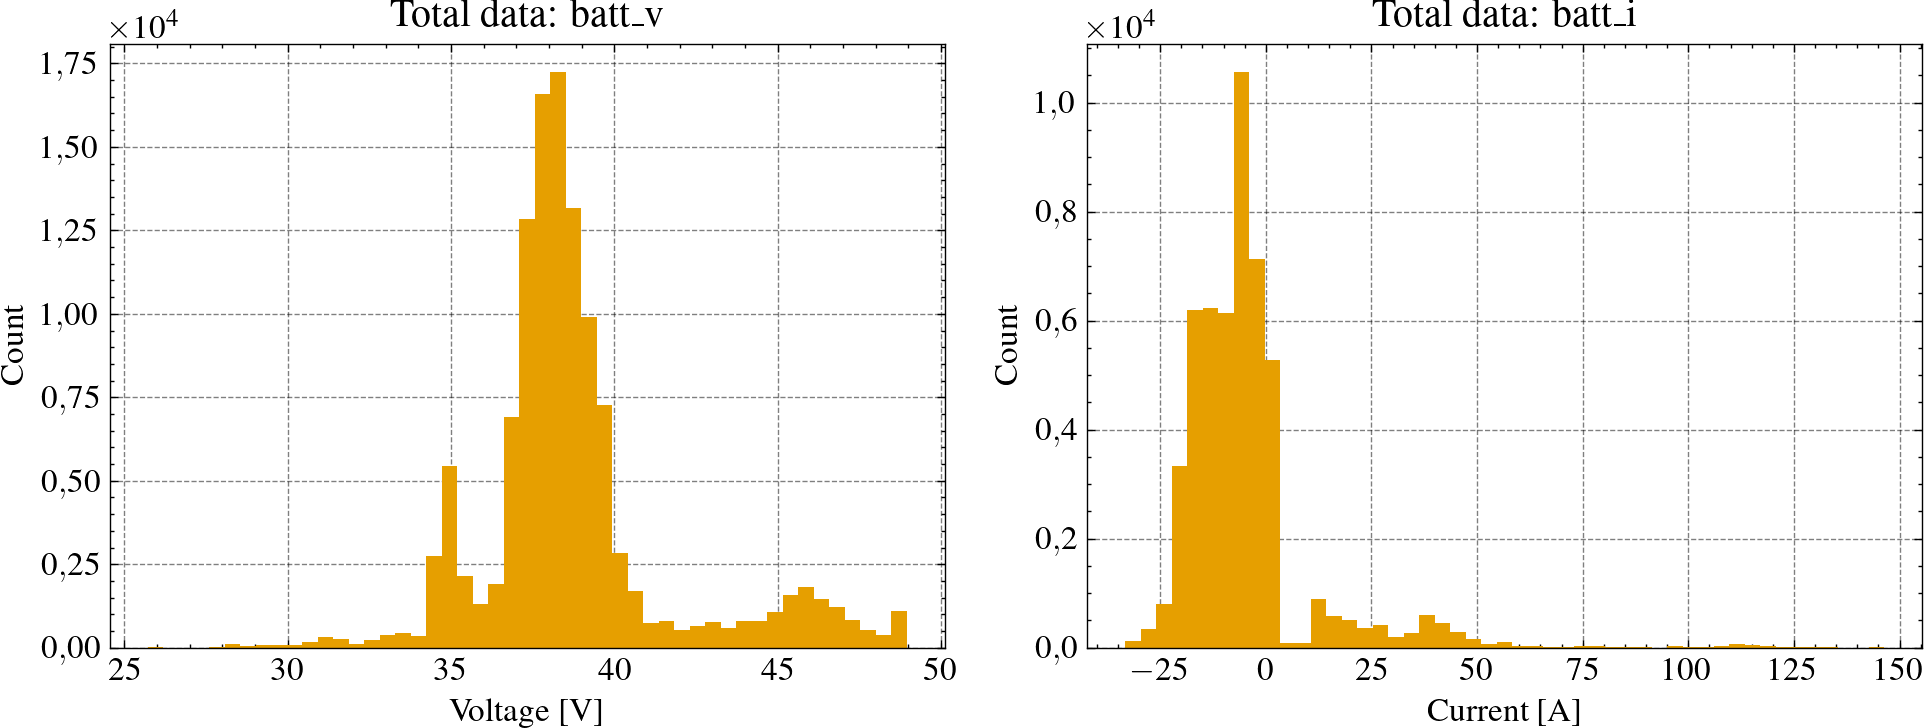

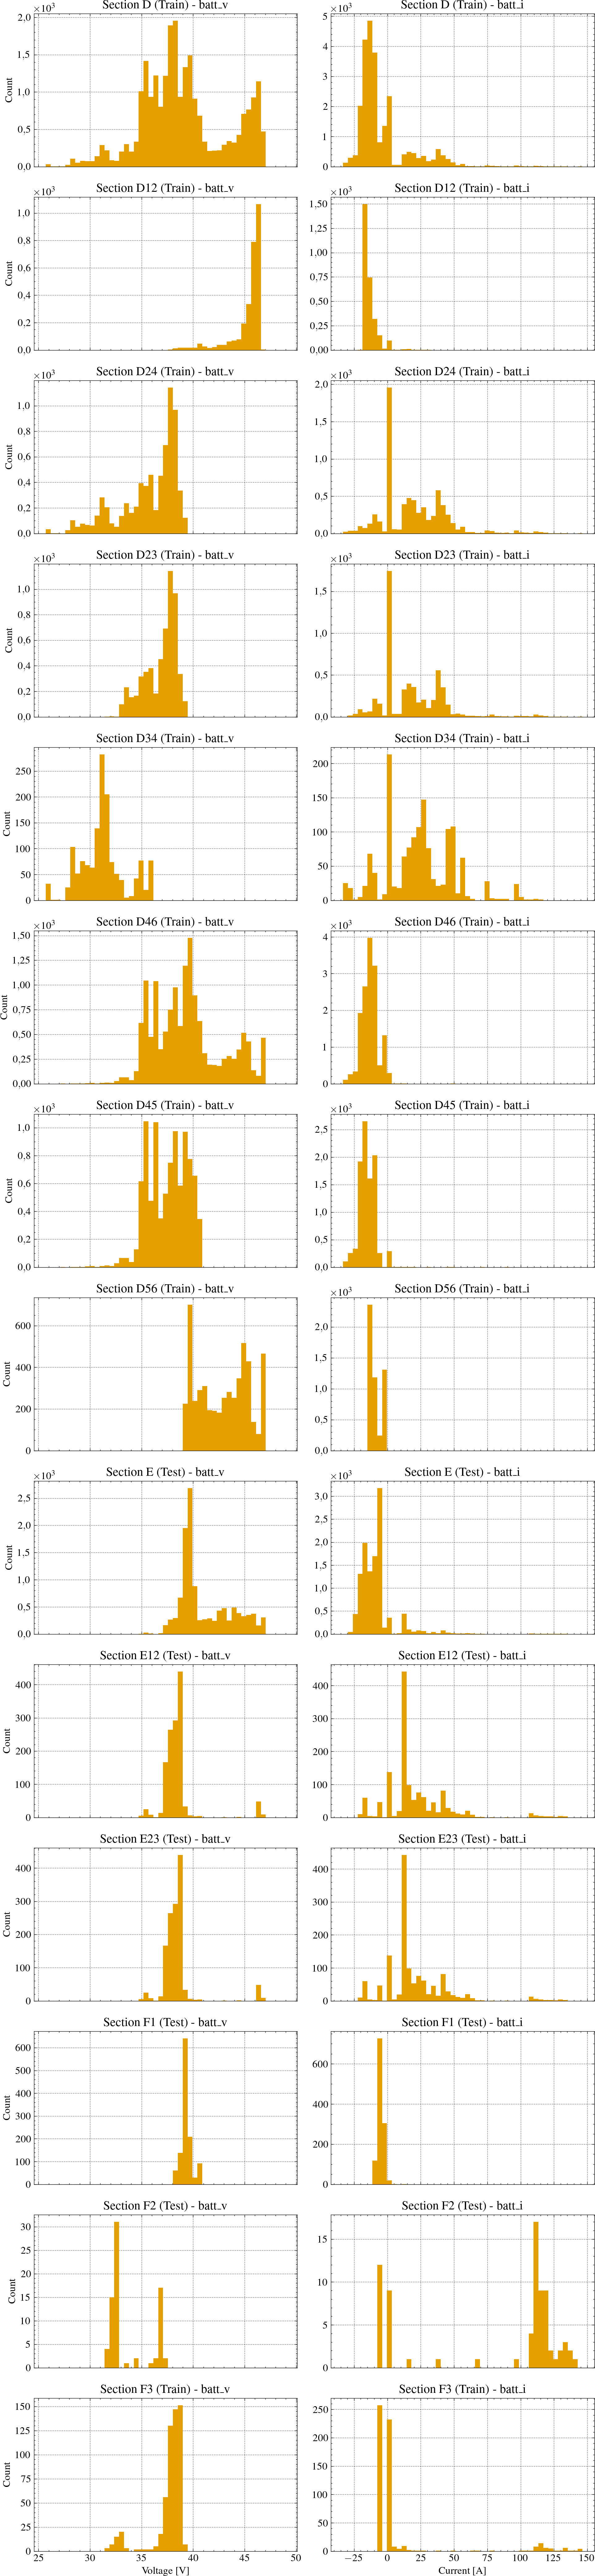

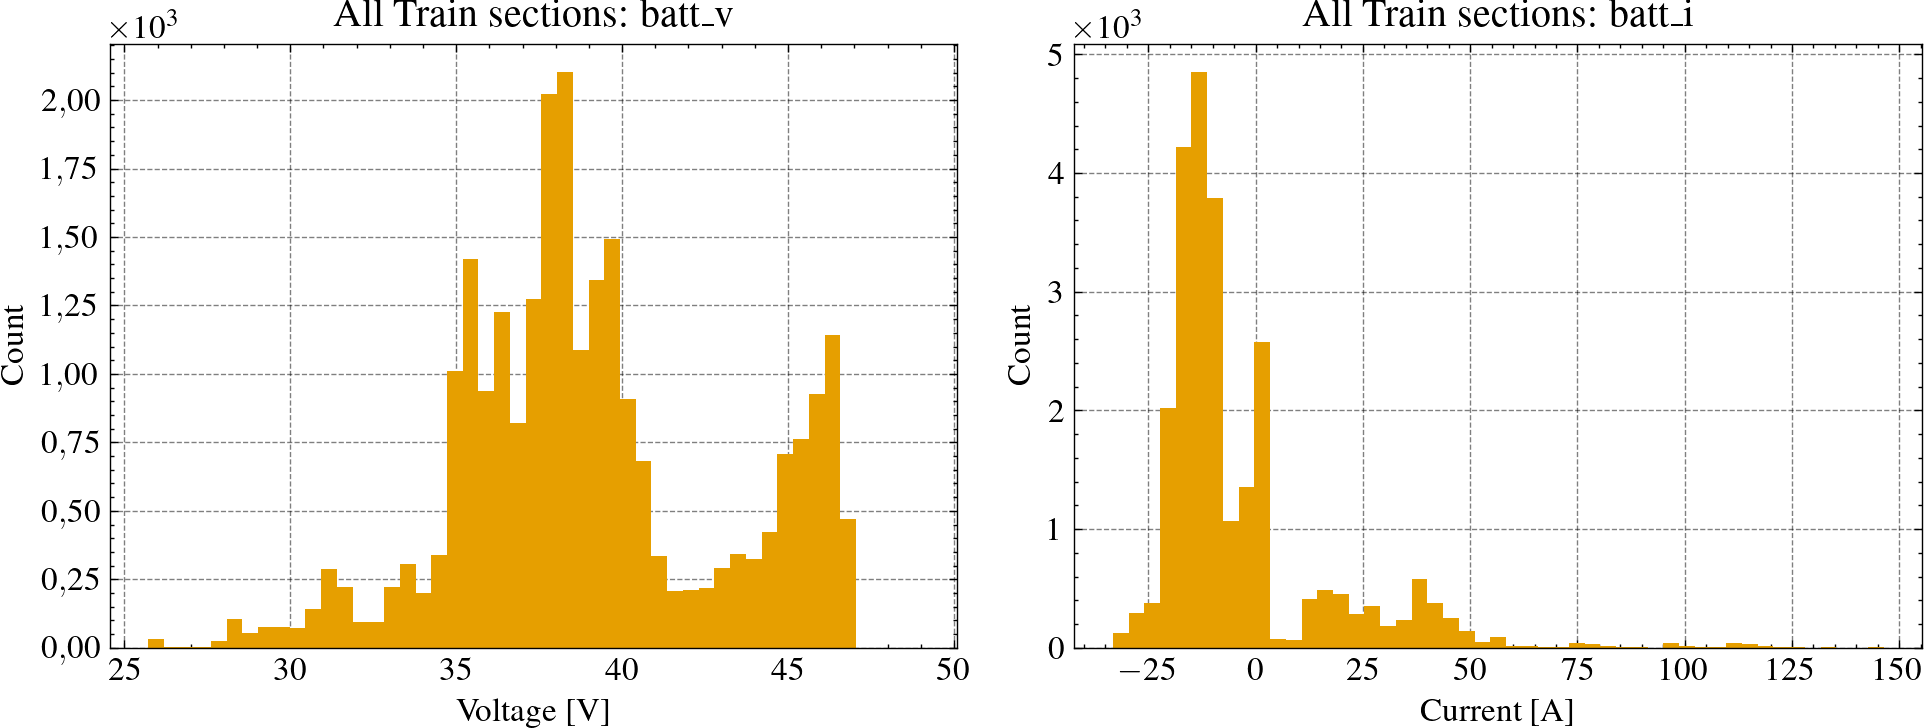

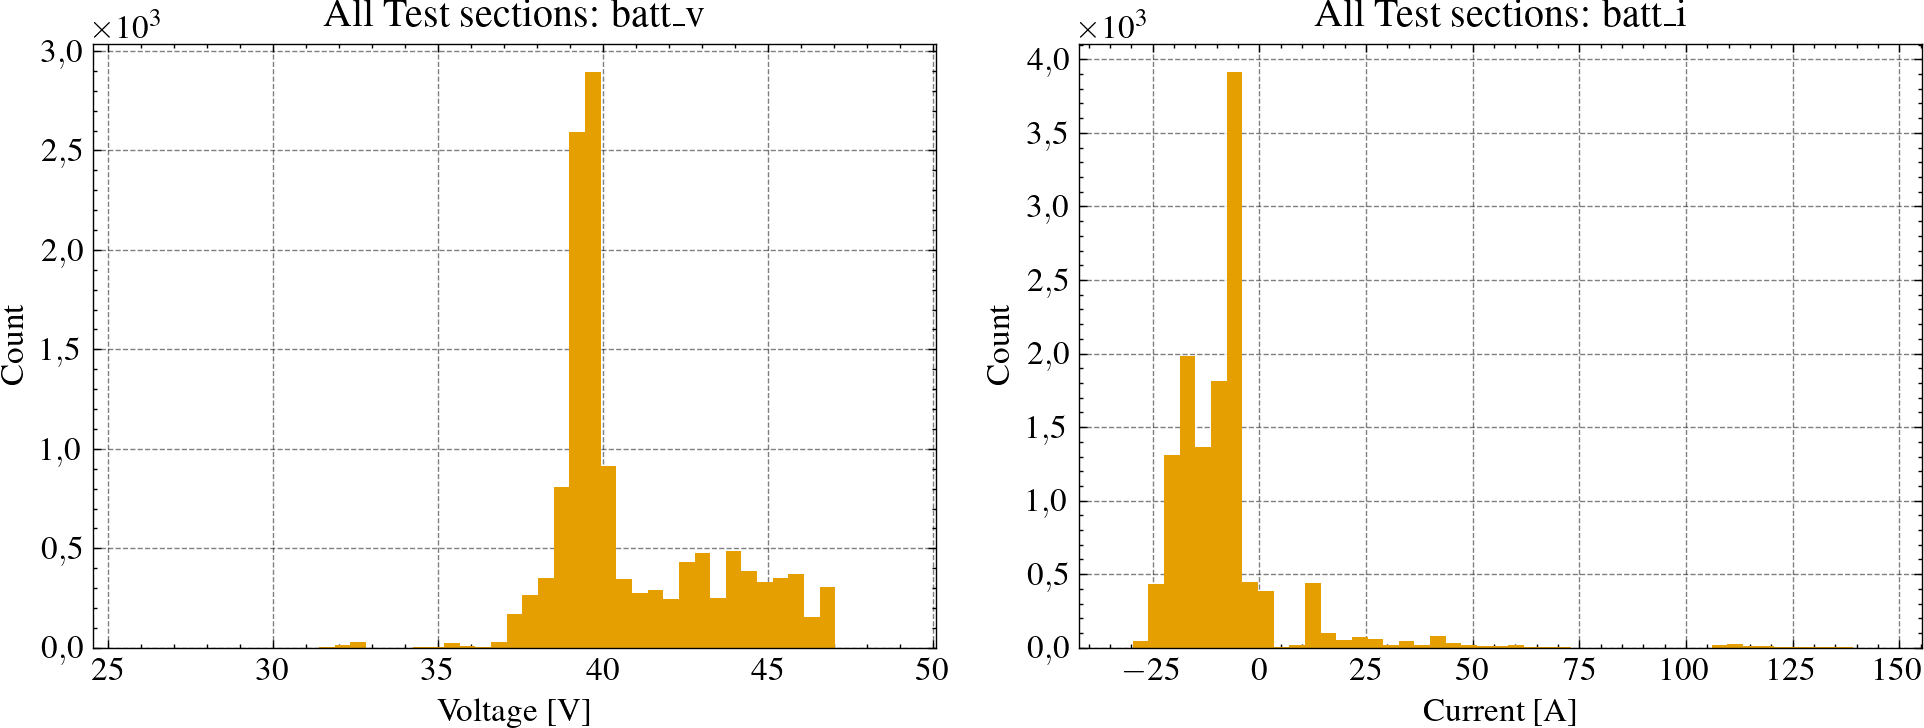

In [4]:
# Dataset Distributions

import numpy as np
import matplotlib.pyplot as plt

# Ensure we have a clean copy of sections with name/start/end
sections_df = sections.reset_index().rename(columns={'index': 'name'})

# Common bins for comparability
v_bins = np.linspace(df['batt_v'].min(), df['batt_v'].max(), 50)
i_bins = np.linspace(df['batt_i'].min(), df['batt_i'].max(), 50)

# ---------------------------------------------------------------------
# 1. Build union masks for train and test (no double-counting overlaps)
# ---------------------------------------------------------------------
train_mask = pd.Series(False, index=df.index)
test_mask = pd.Series(False, index=df.index)

for _, sec in sections_df.iterrows():
    sec_mask = (df.index >= sec['start']) & (df.index <= sec['end'])
    if sec['name'] in train_sections_names:
        train_mask |= sec_mask
    else:
        test_mask |= sec_mask

# Optional sanity check: ensure no overlap between final train and test masks
overlap = train_mask & test_mask
if overlap.any():
    print("Warning: some timestamps are in both train and test masks.")

df_train = df.loc[train_mask]
df_test = df.loc[test_mask]

# ---------------------------------------------------------------------
# 2. Total dataset histograms
# ---------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(df['batt_v'].dropna(), bins=v_bins)
axes[0].set_title('Total data: batt_v')
axes[0].set_xlabel('Voltage [V]')
axes[0].set_ylabel('Count')

axes[1].hist(df['batt_i'].dropna(), bins=i_bins)
axes[1].set_title('Total data: batt_i')
axes[1].set_xlabel('Current [A]')
axes[1].set_ylabel('Count')

fig.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 3. Per-section histograms (each section, Train/Test split)
# ---------------------------------------------------------------------
n_sections = len(sections_df)
fig, axes = plt.subplots(n_sections, 2, figsize=(10, 3 * n_sections), sharex='col')

if n_sections == 1:
    axes = np.array([axes])  # make it 2D for consistency

for idx, (_, sec) in enumerate(sections_df.iterrows()):
    sec_mask = (df.index >= sec['start']) & (df.index <= sec['end'])
    dsec = df.loc[sec_mask]

    is_train = sec['name'] in train_sections_names
    label_prefix = 'Train' if is_train else 'Test'
    title = f"{sec['name']} ({label_prefix})"

    # Voltage
    ax_v = axes[idx, 0]
    ax_v.hist(dsec['batt_v'].dropna(), bins=v_bins)
    ax_v.set_title(f"{title} - batt_v")
    ax_v.set_ylabel('Count')
    if idx == n_sections - 1:
        ax_v.set_xlabel('Voltage [V]')

    # Current
    ax_i = axes[idx, 1]
    ax_i.hist(dsec['batt_i'].dropna(), bins=i_bins)
    ax_i.set_title(f"{title} - batt_i")
    if idx == n_sections - 1:
        ax_i.set_xlabel('Current [A]')

fig.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 4. Aggregated Train dataset histograms
# ---------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(df_train['batt_v'].dropna(), bins=v_bins)
axes[0].set_title('All Train sections: batt_v')
axes[0].set_xlabel('Voltage [V]')
axes[0].set_ylabel('Count')

axes[1].hist(df_train['batt_i'].dropna(), bins=i_bins)
axes[1].set_title('All Train sections: batt_i')
axes[1].set_xlabel('Current [A]')
axes[1].set_ylabel('Count')

fig.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 5. Aggregated Test dataset histograms
# ---------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(df_test['batt_v'].dropna(), bins=v_bins)
axes[0].set_title('All Test sections: batt_v')
axes[0].set_xlabel('Voltage [V]')
axes[0].set_ylabel('Count')

axes[1].hist(df_test['batt_i'].dropna(), bins=i_bins)
axes[1].set_title('All Test sections: batt_i')
axes[1].set_xlabel('Current [A]')
axes[1].set_ylabel('Count')

fig.tight_layout()
plt.show()


# Battery Equivalent Circuit Model


In [ ]:
import numpy as np
import control as ct


def lut_interp(lut: np.array, x: float) -> float:
    """
    Returns y = f(x) by performing a linear interpolation on the LUT.

    Parameters:
    - lut: 1D numpy array where each index corresponds to an evenly spaced percentage of x.
           For example, [12.2, 5.5, 9.3] corresponds to:
           0% -> 12.2, 50% -> 5.5, and 100% -> 9.3.
    - x: A float between 0 and 1 representing the percentage (e.g., 0.3 for 30%).

    Returns:
    - y: The interpolated value.
    """
    n = len(lut)

    if n == 0:
        raise ValueError("LUT cannot be empty.")
    if n == 1:
        return lut[0]

    # Map x to an index in the LUT
    pos = x * (n - 1)
    lower_index = int(np.floor(pos))

    if lower_index >= n - 1:
        return lut[-1]
    if lower_index < 0:
        return lut[0]

    interp_frac = pos - lower_index

    # Linear interpolation between lut[i] and lut[i+1]
    return lut[lower_index] * (1 - interp_frac) + lut[lower_index + 1] * interp_frac


class Battery:
    # ---------------------------------------------------------------------
    # Internal helpers for gassing branch
    # ---------------------------------------------------------------------
    @staticmethod
    def _gassing_params(params: dict):
        """
        Extract gassing model parameters with safe defaults that disable gassing
        if not provided.
        """
        # Effective Tafel pre-exponential (A, pack level)
        I_g0 = params['batt_I_g0']
        # Tafel slope parameter (V)
        a_g = params['batt_a_g']
        # Gassing onset voltage (V, pack level)
        E_g = params['batt_E_g']  # huge default -> effectively n]
        # Optional max fraction of |terminal current| that can go into gassing
        max_frac = params['batt_I_gas_max_frac']

        return I_g0, a_g, E_g, max_frac

    @classmethod
    def _gassing_current(cls, v: float, i: float, params: dict) -> float:
        """
        Parasitic gassing current i_gas (A), with sign consistent with i.

        Sign convention:
        - i > 0: discharge
        - i < 0: charge
        Gassing is only allowed during charge (i < 0) and at voltages above E_g.

        Returns a **negative** current during charge when active, 0 otherwise.
        """
        I_g0, a_g, E_g, max_frac = cls._gassing_params(params)

        # If parameterization disables gassing
        if I_g0 <= 0 or a_g <= 0:
            return 0.0

        # Only consider gassing during charge
        if i >= 0.0:
            return 0.0

        # Only above gassing onset voltage
        if v <= E_g:
            return 0.0

        # Overvoltage
        eta_g = v - E_g

        # Tafel-like current (positive magnitude)
        i_mag = I_g0 * np.exp(eta_g / a_g)

        # Gassing current has same sign as charge current (negative)
        i_gas = -i_mag

        # Do not allow |i_gas| to exceed a fraction of |i|
        max_i_gas = max_frac * abs(i)
        if abs(i_gas) > max_i_gas:
            i_gas = -max_i_gas

        return i_gas

    # ---------------------------------------------------------------------
    # Public API (kept unchanged)
    # ---------------------------------------------------------------------
    @classmethod
    def initial_state(cls, X0: dict, U0, params: dict):
        # Params
        batt_R_1 = params['batt_R_1']
        batt_k_V_OC_coeffs = params['batt_k_V_OC_coeffs']
        batt_R_0 = params['batt_R_0']

        # Input Initial Conditions
        batt_z_0 = X0['batt_z']  # initial SOC

        # Inputs
        batt_i_0 = U0[0]  # Battery current [A]

        # Interpolate parameters at initial SOC
        batt_ocv_0 = lut_interp(batt_k_V_OC_coeffs, batt_z_0)

        # Approximate initial terminal voltage from simple Ohm's law + RC drop
        # We assume initial RC drop corresponds to "main" current (i - i_gas).
        # Compute a first guess for v, then i_gas, then refine i_main.
        v_guess = batt_ocv_0 - batt_R_0 * batt_i_0

        # First gassing estimate
        batt_i_gas_0 = cls._gassing_current(v_guess, batt_i_0, params)
        batt_i_main_0 = batt_i_0 - batt_i_gas_0

        # Initial condition for RC branch
        batt_v_C_1_0 = batt_i_main_0 * batt_R_1

        return np.array([batt_z_0, batt_v_C_1_0])

    @classmethod
    def _update(cls, t, x, u, params: dict):
        # Params
        (
            batt_eta,
            batt_Q,
            batt_R_1,
            batt_C_1,
            batt_k_V_OC_coeffs,
            batt_R_0,
        ) = (
            params['batt_eta'],
            params['batt_Q'],
            params['batt_R_1'],
            params['batt_C_1'],
            params['batt_k_V_OC_coeffs'],
            params['batt_R_0'],
        )

        # Inputs
        batt_i = u[0]  # Battery current [A]

        # States
        batt_z = x[0]      # SOC [0..1]
        batt_v_C_1 = x[1]  # RC branch voltage [V]

        # Interpolate parameters at current SOC
        batt_ocv = lut_interp(batt_k_V_OC_coeffs, batt_z)

        # Terminal voltage (before splitting into main/gassing current)
        batt_v = batt_ocv - batt_v_C_1 - batt_R_0 * batt_i

        # Parasitic gassing current (negative during charge when active)
        batt_i_gas = cls._gassing_current(batt_v, batt_i, params)

        # Main Faradaic current (effective current for SOC and polarization)
        batt_i_main = batt_i - batt_i_gas

        # System of differential equations
        # SOC dynamics: only main current changes SOC
        d_batt_z = -batt_eta * batt_i_main / batt_Q

        # RC branch dynamics: driven by main current only
        d_batt_v_C_1 = -(batt_v_C_1 / (batt_R_1 * batt_C_1)) + (batt_i_main / batt_C_1)

        return np.array([d_batt_z, d_batt_v_C_1])

    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Params
        batt_k_V_OC_coeffs, batt_R_0 = (
            params['batt_k_V_OC_coeffs'],
            params['batt_R_0'],
        )

        # Inputs
        batt_i = u[0]  # Battery current [A]

        # States
        batt_z = x[0]      # SOC [0..1]
        batt_v_C_1 = x[1]  # RC branch voltage [V]

        # Output equations
        batt_ocv = lut_interp(batt_k_V_OC_coeffs, batt_z)
        batt_v = batt_ocv - batt_v_C_1 - batt_R_0 * batt_i

        # Outputs are unchanged externally:
        #  - batt_v: terminal voltage
        #  - batt_z: SOC
        #  - batt_ocv: open-circuit voltage
        return np.array([batt_v, batt_z, batt_ocv])

    @classmethod
    def build(cls, params: dict):
        return ct.NonlinearIOSystem(
            cls._update,
            cls._outputs,
            name='battery',
            states=('batt_z', 'batt_v_C_1'),
            inputs=('batt_i',),
            outputs=('batt_v', 'batt_z', 'batt_ocv'),
            params=params,
        )

Battery.build({})

<NonlinearIOSystem battery: ['batt_i'] -> ['batt_v', 'batt_z', 'batt_ocv']>

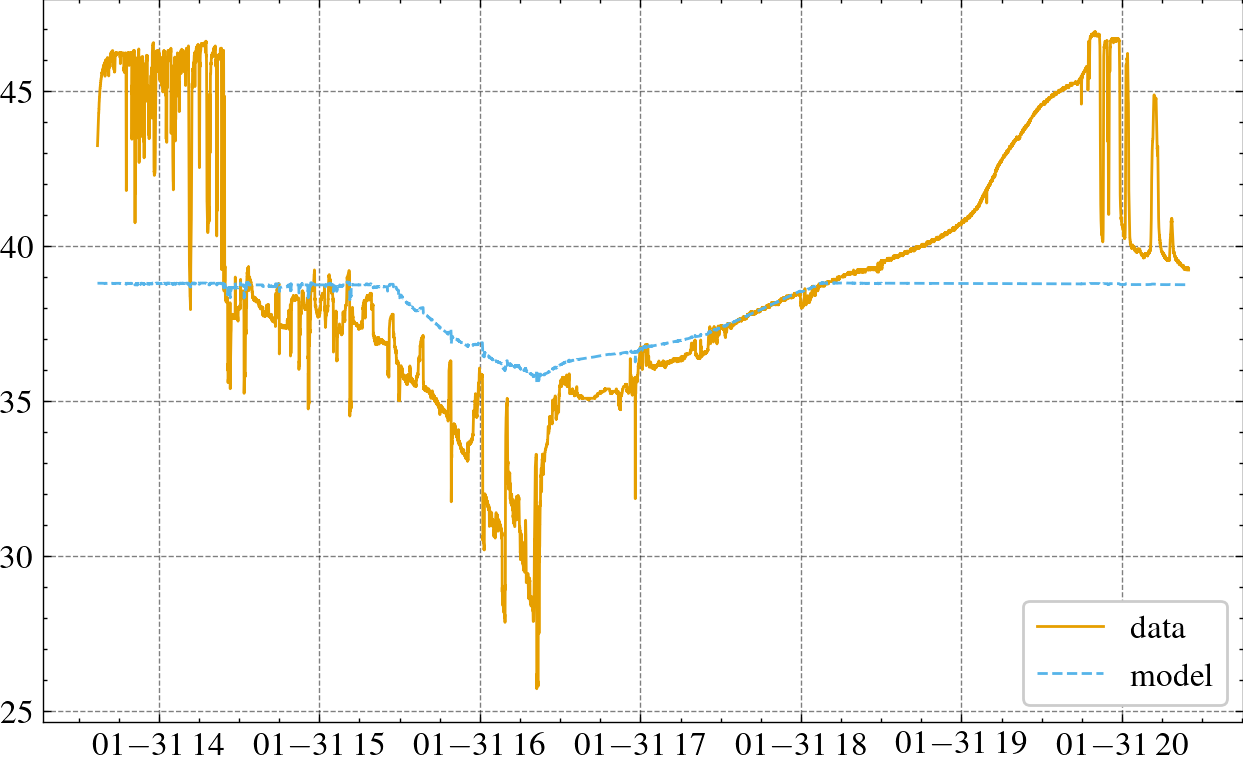

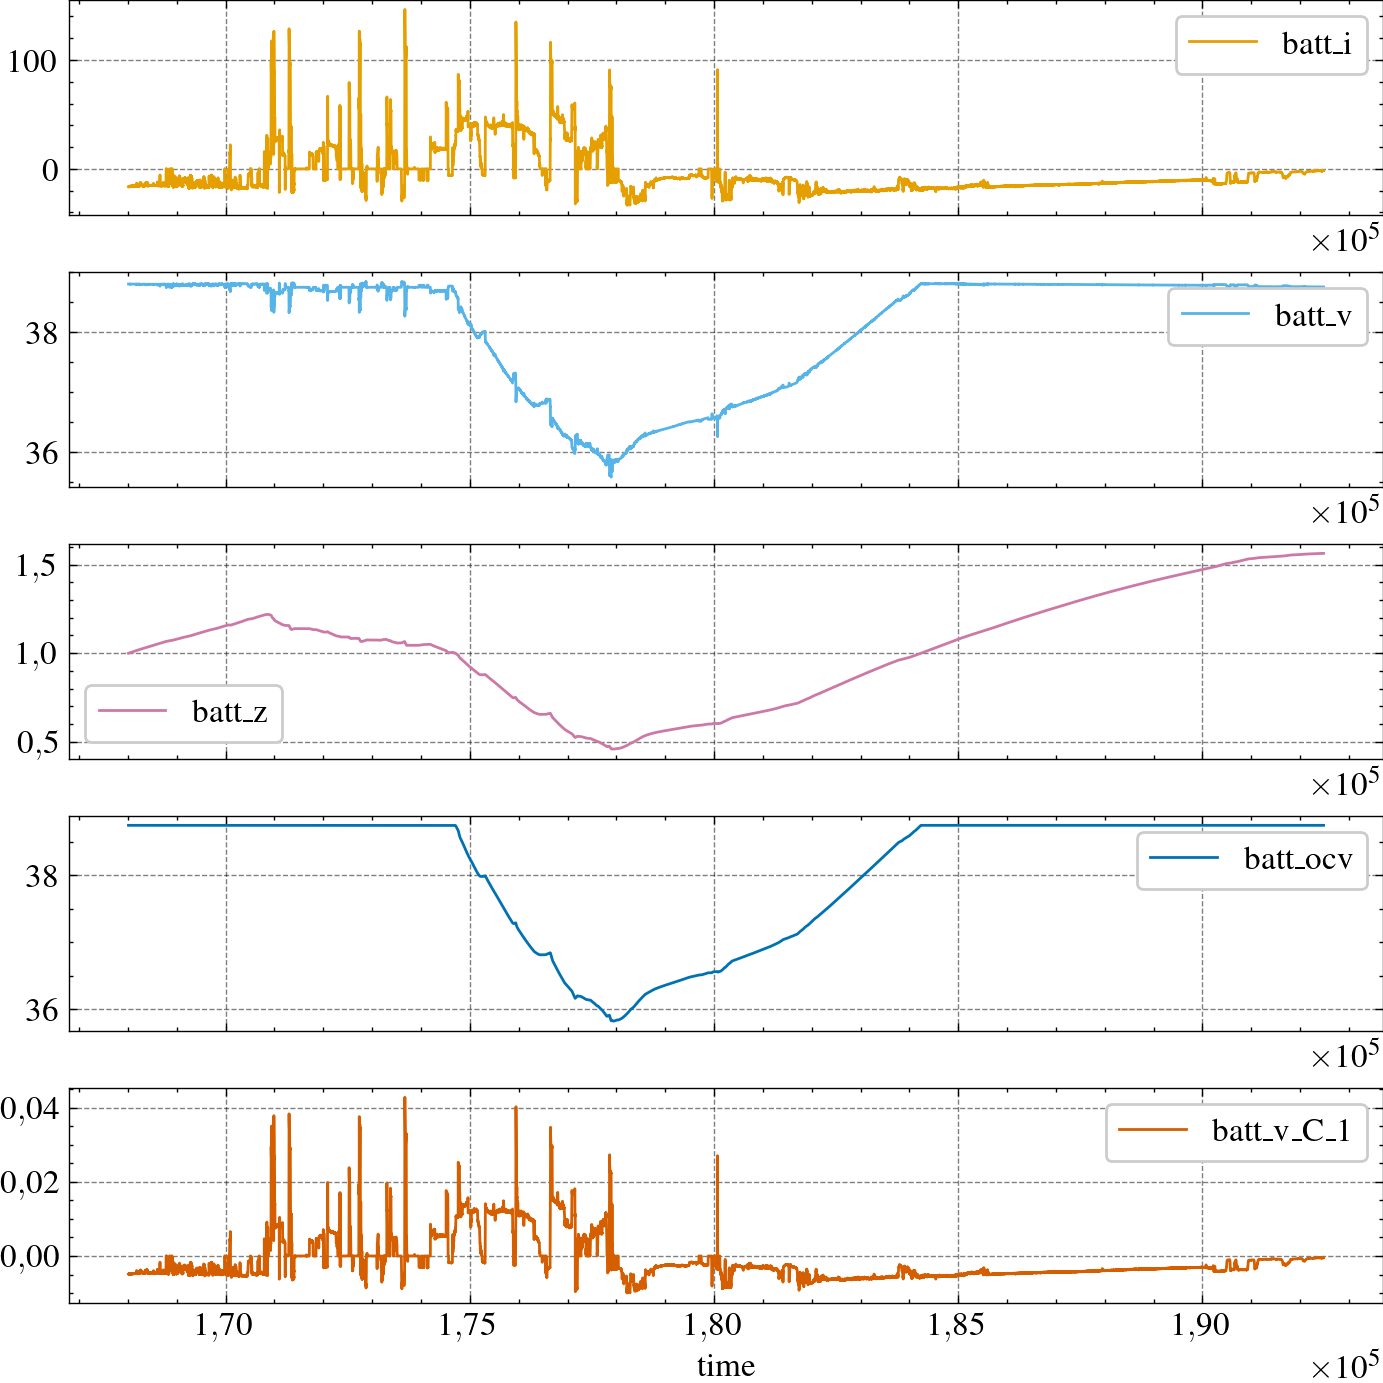

In [175]:
batt_name = 'D35'
cell_amps_hour = 48
series_cells = 3
parallel_cells = 1
cell_voltage = 12
nominal_Q_Ah = parallel_cells * cell_amps_hour  # Capacity, in Amper-hour
batt_Q = nominal_Q_Ah * 3600 # [Ah] -> [As]
nominal_voltage = series_cells * cell_voltage
batt_ocv_lut = np.array([10.7865, 10.9583, 11.1160, 11.2607, 11.3937, 11.5161, 11.6292, 11.7343, 11.8324, 11.9249, 12.0129, 12.0976, 12.1803, 12.2622, 12.3444, 12.4283, 12.5150, 12.6056, 12.7016, 12.8039, 12.9139])
initial_SOC = 1

battery_params = {
    'batt_eta': 1.0,
    'batt_Q': 48 * 3600.0,

    # --- OCV (pack-level) ---
    'batt_k_V_OC_coeffs': batt_ocv_lut*series_cells,

    # --- ohmic branch ---
    'batt_R_0_coeffs': np.array([1e-3])*series_cells,

    # --- diffusion/polarization RC ---
    'batt_R_1_coeffs': np.array([1e-4])*series_cells,
    'batt_C_1_coeffs': np.array([10])*series_cells,

    # --- gassing branch (Ceraolo/Giglioli) ---
    'batt_I_g0': 1e-4,          # A, pre-exponential for Tafel branch
    'batt_a_g': 0.5,           # V, Tafel slope
    'batt_E_g': 36,           # V, onset of gassing for your pack
    'batt_I_gas_max_frac': 0.99, # optional, cap |i_gas| ≤ 90% of |i|
}


if True:
    # Select the optimization data
    data_cols = ['batt_v']
    input_cols = ['batt_i']
    train_section = train_sections[0]

    df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols]#[:7000]

    # Time array
    T = np.ascontiguousarray(df_train['t'].to_numpy())

    # Inputs
    U = np.ascontiguousarray(df_train[['batt_i']].to_numpy().T)

    # Model
    battery = Battery.build(battery_params)

    # Initial state
    X0 = Battery.initial_state(
        X0 = {
            "batt_z": initial_SOC,              # dimensionless SOC in [0, 1]
            "batt_v": float(df_train["batt_v"].iloc[0]),  # initial PACK voltage [V]
        },
        U0=U[:,0],
        params=battery_params
    )

    # Simulation
    res = ct.input_output_response(battery, T=T, U=U, X0=X0, solve_ivp_method='Radau', solve_ivp_kwargs=dict(max_step=1))
    ydata = res.to_pandas().set_index('time')#[sorted(list(set(res.output_labels + res.state_labels)))]

    plt.figure()
    plt.plot(df_train.index, df_train['batt_v'], label='data')
    plt.plot(df_train.index, ydata['batt_v'], label='model')
    plt.legend(loc='lower right')
    plt.show()

    ydata.plot(subplots=True, figsize=(7,7))
    plt.show()

# Train dataset SOC estimation

In [7]:
def evaluate_soc(df, batt_Q: float,initial_SOC: float, section_name: str, section_decription: str="") -> pd.DataFrame:
    section = next(s for s in all_sections if s['name'] == section_name)
    df_section = df.loc[(df.index >= section['start']) & (df.index <= section['end']), ['t'] + data_cols + input_cols].resample('1s').mean().interpolate(method='time')
    compute_df_capacity(df_section, batt_Q/3600, initial_SOC, inplace=True)
    compute_df_soc(df_section, batt_Q/3600, inplace=True)
    # df_section['batt_z'] = np.clip(df_section['batt_z'], 0, 1)
    
    ending_SOC = float(df_section['batt_z'].iloc[-1])

    print(f'Section {section_name}: SOC went from {initial_SOC} to {ending_SOC}')

    return df_section


In [8]:
# initial_SOC = 1.0
# batt_Q = nominal_Q_Ah * 3600
# df_section = evaluate_soc(
#     df=df,
#     initial_SOC=initial_SOC,
#     batt_Q=batt_Q,
#     section_name='Section D',
# )

# initial_SOC_dict = {
#     'Section D': df_section['batt_z'].loc[D1],
#     'Section D12': df_section['batt_z'].loc[D1],
#     'Section D24': df_section['batt_z'].loc[D2],
#     'Section D23': df_section['batt_z'].loc[D2],
#     'Section D34': df_section['batt_z'].loc[D3],
#     'Section D46': df_section['batt_z'].loc[D4],
#     'Section D45': df_section['batt_z'].loc[D4],
#     'Section D56': df_section['batt_z'].loc[D5],
# }
# ending_SOC_dict = {
#     'Section D': df_section['batt_z'].loc[D6 - pd.Timedelta('1s')],
#     'Section D12': df_section['batt_z'].loc[D2],
#     'Section D24': df_section['batt_z'].loc[D4],
#     'Section D23': df_section['batt_z'].loc[D3],
#     'Section D34': df_section['batt_z'].loc[D4],
#     'Section D46': df_section['batt_z'].loc[D6 - pd.Timedelta('1s')],
#     'Section D45': df_section['batt_z'].loc[D5],
#     'Section D56': df_section['batt_z'].loc[D6 - pd.Timedelta('1s')],
# }
# display('initial_SOC_dict:', initial_SOC_dict)
# display('ending_SOC_dict:', ending_SOC_dict)

In [9]:
# # TODO: idea: fit Q on full D, 

# # Cleaned params for our sectorized optimization strategy
# initial_params = dict(
#     # Capacity / efficiencies
#     batt_Q      = batt_Q,  # 172800 C per 12 V block
# )

# initial_SOC = 1.0
# batt_Q = 1.0
# df_section = evaluate_soc(
#     df=df,
#     initial_SOC=initial_SOC,
#     batt_Q=batt_Q,
#     section_name='Section D',
# )

# df_section['batt_z'] -= df_section['batt_z'].min()

# df_section[['batt_v', 'batt_z', 'batt_i']].plot(subplots=True, figsize=(7,3))
# plt.show()

# # section_df.loc[D6 - pd.Timedelta('1s')]

# Optimization

In [10]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.nelder import NelderMead
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.isres import ISRES
from pymoo.algorithms.soo.nonconvex.es import ES
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
from pymoo.algorithms.soo.nonconvex.pattern import PatternSearch
from pymoo.operators.sampling.lhs import LHS
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.parallelization.starmap import StarmapParallelization
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.variable import Real
from multiprocessing.pool import ThreadPool
from multiprocessing import Pool

def model_function(T, U, X0, **params):
    return ct.input_output_response(
        Battery.build(params=params),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method='Radau',
    ).to_pandas()

# Constraints
from dataclasses import dataclass
from typing import Literal
import numpy as np

ConstraintKind = Literal[
    "simple_order",
    "simple_gap",
    "deep_extra",
    "beta_z_min",
    "beta_z_max",
    "smoothness",
]

@dataclass
class ParamConstraint:
    """
    Generic constraint usable by pymoo: g(x) <= 0 when satisfied.
    Picklable, works with multiprocessing.
    """
    kind: ConstraintKind

    # indices into the decision vector x
    idx_a: int | None = None
    idx_b: int | None = None
    idx_c: int | None = None  # third index if needed (e.g. z_deep)

    # generic scalars for constraints
    gap: float = 1.0          # used by simple_gap
    limit: float = 0.0        # used by deep_extra, beta_z_min/max

    def __call__(self, x: np.ndarray) -> float:
        if self.kind == "simple_gap":
            # tau_b >= gap * tau_a -> gap*tau_a - tau_b <= 0
            return self.gap * x[self.idx_a] - x[self.idx_b]

        if self.kind == "simple_order":
            # R_a < R_b -> R_a - R_b <= 0
            return x[self.idx_a] - x[self.idx_b]

        if self.kind == "deep_extra":
            # deep-discharge extra "ohms" at z ~ 0:
            #   R_extra = R0_deep + k_deep * max(0, z_deep)
            # constraint: R_extra <= limit  -> R_extra - limit <= 0
            R0_deep = x[self.idx_a]
            k_deep  = x[self.idx_b]
            z_deep  = x[self.idx_c]
            R_extra = R0_deep + k_deep * max(0.0, z_deep)
            return R_extra - self.limit

        if self.kind == "beta_z_min":
            # beta * z_deep >= limit  -> limit - beta*z <= 0
            beta   = x[self.idx_a]
            z_deep = x[self.idx_b]
            return self.limit - beta * z_deep

        if self.kind == "beta_z_max":
            # beta * z_deep <= limit  -> beta*z - limit <= 0
            beta   = x[self.idx_a]
            z_deep = x[self.idx_b]
            return beta * z_deep - self.limit
        
        if self.kind == "smoothness":
            return abs(x[self.idx_a] - 2*x[self.idx_b] + x[self.idx_c]) - self.limit

        return 0.0

class BatteryWithSocOptimizationProblem(ElementwiseProblem):
    def __init__(
        self,
        model,
        model_function,
        training_data,
        training_data_columns,
        model_params,
        opt_params_bounds,
        input_columns,
        data_scaler=RobustScaler,
        constraint_funcs=None,
        print_exceptions=False,
        **kwargs,
    ):
        assert all(
            "min" in pb and "max" in pb for pb in opt_params_bounds.values()
        ), "All opt_params_bounds must have 'min' and 'max' keys"

        self.model = model
        self.model_function = model_function
        self.model_params = model_params
        self.data_scaler_cls = data_scaler
        self.training_data_columns = training_data_columns  # e.g. ['batt_v', 'batt_z']
        self.opt_param_names = list(opt_params_bounds.keys())
        self.input_columns = input_columns
        self.print_exceptions = print_exceptions
        self.constraint_funcs = constraint_funcs or []

        # Keep the raw training data (no batt_z yet)
        self.training_data_raw = training_data.copy(deep=True)

        # Time vector
        self.T = np.ascontiguousarray(training_data['t'].to_numpy())

        # Inputs
        self.U = np.ascontiguousarray(training_data[input_columns].to_numpy().T)

        # --- Fit scaler once using a baseline initial_SOC0 (e.g. 0.5) ---
        df0 = self.training_data_raw.copy()
        initial_SOC0 = 0.5
        batt_Q_Ah = self.model_params['batt_Q'] / 3600
        compute_df_capacity(df0, batt_Q_Ah, initial_SOC0, inplace=True)
        compute_df_soc(df0, batt_Q_Ah, inplace=True)
        Y0 = df0[self.training_data_columns].to_numpy()
        self.data_scaler = self.data_scaler_cls().fit(Y0)

        super().__init__(
            n_var=len(self.opt_param_names),
            n_obj=1,
            n_constr=len(self.constraint_funcs),
            xl=np.array([p["min"] for p in opt_params_bounds.values()]),
            xu=np.array([p["max"] for p in opt_params_bounds.values()]),
            **kwargs,
        )

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = self.objective_function(x, *args, **kwargs)

        if self.constraint_funcs:
            # Each constraint func should return a scalar ≤ 0 when satisfied
            g = [func(x) for func in self.constraint_funcs]
            out["G"] = np.array(g)

    def objective_function(self, x, *args, **kwargs):
        # Map decision vector to parameters
        params_dict = {name: x[i] for i, name in enumerate(self.opt_param_names)}
        initial_SOC = params_dict.pop('batt_z')
        model_params = self.model_params | convert_to_model_params(params_dict)
        batt_Q_Ah = model_params['batt_Q'] / 3600

        # Recompute SOC trajectory from candidate batt_z_0
        df_temp = self.training_data_raw.copy()
        compute_df_capacity(df_temp, batt_Q_Ah, initial_SOC, inplace=True)
        compute_df_soc(df_temp, batt_Q_Ah, inplace=True)

        # Ground truth (voltage + SOC) for this candidate
        y_true = df_temp[self.training_data_columns].to_numpy()
        scaled_y_true = self.scale_data(y_true)

        # Initial state
        X0 = self.model.initial_state(
            X0={
                'batt_z': df_temp['batt_z'].iloc[0],
                'batt_v': df_temp['batt_v'].iloc[0],
            },
            U0=self.U[:, 0],
            params=model_params,
        )

        # Run the simulation
        try:
            model_predictions = self.model_function(
                T=self.T, U=self.U, X0=X0, **model_params
            )[self.training_data_columns].to_numpy()
        except Exception as e:
            if self.print_exceptions:
                print(f"Exception from model_function: {e}")
            return 1e9  # Penalize parameters that break the model

        # Scale model predictions
        scaled_model_predictions = self.scale_data(model_predictions)

        return mean_squared_error(scaled_y_true, scaled_model_predictions)

    def scale_data(self, data):
        return self.data_scaler.transform(data)

    def rescale_data(self, data):
        return self.data_scaler.inverse_transform(data)

def run_battery_optimization(
    model,
    model_params: dict,
    section_name: str,
    params_bounds: dict,
    initial_SOC: float,
    df,
    constraint_funcs: list,
    plot_results=True,
    plot_simulation=True,
    algorithm_pop_size_k=10,
    termination_period=20,
):
    train_section = next(s for s in train_sections if s['name'] == section_name)
    print(''.join(['=']*100))
    print('\n\nTraining on section:', section_name)

    # Define optimization and input data columns
    data_cols = ['batt_v']
    input_cols = ['batt_i']

        # Extract and resample training data
    df_train = df.loc[
        (df.index >= train_section['start']) & (df.index <= train_section['end']),
        ['t'] + data_cols + input_cols
    ].resample('1s').mean().interpolate(method='time')

    lut_coeffs = [
        # {'name': 'batt_ocv_lut', 'lut_size': 21, 'bounds': (10.5, 13.5)},
    ]
    for coeff in lut_coeffs:
        name = coeff['name']
        values_bounds = coeff['bounds']
        lut_size = coeff['lut_size']
        for i in range(0, lut_size):
            params_bounds[f'{name}_{i}'] = dict(min=values_bounds[0], max=values_bounds[1])

    # Initialize the multiprocessing pool and parallel runner
    n_processes = 32
    pool = Pool(processes=n_processes)
    runner = StarmapParallelization(pool.starmap)

    try:
        # Set up the optimization problem
        if 'batt_z' in params_bounds:
            problem = BatteryWithSocOptimizationProblem(
                model=model,
                model_function=model_function,
                training_data=df_train,
                training_data_columns=data_cols,
                model_params=model_params,
                opt_params_bounds=params_bounds,
                input_columns=input_cols,
                data_scaler=MinMaxScaler,
                constraint_funcs=constraint_funcs,
                print_exceptions=False,
                elementwise_runner=runner,
            )
        else:
            # Compute battery capacity and SOC using the hyperparameter initial_SOC
            batt_Q_Ah = model_params['batt_Q'] / 3600
            compute_df_capacity(df_train, batt_Q_Ah, initial_SOC, inplace=True)
            compute_df_soc(df_train, batt_Q_Ah, inplace=True)

            # Initial state
            input_initial_state = dict(
                batt_z=df_train['batt_z'].iloc[0],
                batt_v=df_train['batt_v'].iloc[0],
            )

            problem = MyOptimizationProblem(
                model=model,
                model_function=model_function,
                training_data=df_train,
                training_data_columns=data_cols,
                model_params=model_params,
                opt_params_bounds=params_bounds,
                input_initial_state=input_initial_state,
                input_columns=input_cols,
                data_scaler=MinMaxScaler,
                constraint_funcs=constraint_funcs,
                print_exceptions=False,
                elementwise_runner=runner,
            )

        # Configure the optimization algorithm (Differential Evolution in this case)
        algorithm = DE(
            pop_size=algorithm_pop_size_k * len(params_bounds),
            sampling=LHS(),
            variant="DE/rand/1/bin",
            F=0.5,
            CR=0.9,
        )
        # algorithm = CMAES(
        #     pop_size=32,     # 16–64 is typical
        #     sigma=0.3        # initial step size in normalized space
        # )

        # Set termination criteria
        termination = DefaultSingleObjectiveTermination(
            xtol=1e-8,
            cvtol=1e-6,
            ftol=1e-6,
            period=termination_period,
            n_max_gen=10000,
            n_max_evals=1000000,
        )

        # Run the optimization
        result = minimize(
            problem,
            algorithm,
            termination=termination,
            seed=42,
            verbose=True,
            save_history=True,
        )
    finally:
        pool.close()
        pool.join()

    # Retrieve and display the best parameters
    raw_params = {k: result.X[i] for i, k in enumerate(params_bounds.keys())}
    best_params = convert_to_model_params(raw_params)
    original_params = {k: convert_to_model_params(model_params).get(k) for k in best_params.keys()}
    print("Original parameters were:")
    display(original_params)
    print("Best parameters found:")
    display(best_params)
    print("Objective value at solution:", result.F)

    # Plot optimization results
    if plot_results:
        plot_optimization_params(result, params_bounds)
        plot_optimization_error(result)

    initial_SOC_opt = best_params.get("batt_z", initial_SOC)
    batt_Q_Ah  = (model_params | best_params)['batt_Q'] / 3600

    # Simulate the model with the optimized parameters
    df_train = df.loc[
        (df.index >= train_section['start']) & (df.index <= train_section['end']),
        ['t'] + data_cols + input_cols
    ].resample('1s').mean().interpolate(method='time')
    compute_df_capacity(df_train, batt_Q_Ah, initial_SOC_opt, inplace=True)
    compute_df_soc(df_train, batt_Q_Ah, inplace=True)
    T = np.ascontiguousarray(df_train['t'].to_numpy())
    U = np.ascontiguousarray(df_train[input_cols].to_numpy().T)
    X0 = Battery.initial_state(
        X0={
            'batt_z': df_train['batt_z'].iloc[0],
            'batt_v': df_train['batt_v'].iloc[0],
        },
        U0=U[:, 0],
        params=model_params | best_params
    )
    best_fit_data = model_function(T, U, X0, **(model_params | best_params))
    ending_SOC = best_fit_data['batt_z'].iloc[-1]

    if plot_simulation:
        # Plot the comparison for each data column
        for col in data_cols:
            plot_compare(df_train, best_fit_data, col)

    return result, params_bounds, best_params, ending_SOC

def check_fit(section_name, model_params, initial_SOC):
    batt_Q_Ah = model_params['batt_Q'] / 3600
    section = next(s for s in all_sections if s['name'] == section_name)

    data_cols = ['batt_v']
    input_cols = ['batt_i']
    df_section = df.loc[(df.index >= section['start']) & (df.index <= section['end']), ['t'] + data_cols + input_cols]
    compute_df_capacity(df_section, batt_Q_Ah, initial_SOC, inplace=True)
    compute_df_soc(df_section, batt_Q_Ah, inplace=True)

    # Time array
    T = np.ascontiguousarray(df_section['t'].to_numpy())

    # Inputs
    U = np.ascontiguousarray(df_section[input_cols].to_numpy().T)

    # Model
    battery = Battery.build(model_params)

    # Initial state
    X0 = Battery.initial_state(
        X0={
            'batt_z': initial_SOC,
            'batt_v': df_section['batt_v'].iloc[0],
        },
        U0=U[:,0],
        params=model_params
    )

    # Simulation
    res = ct.input_output_response(battery, T=T, U=U, X0=X0, solve_ivp_method='Radau')
    ydata = res.to_pandas().set_index('time')[sorted(data_cols)]

    for column in ydata.columns:
        plot_compare(df_section, ydata, column, show=True)

In [11]:
# Cleaned params for our sectorized optimization strategy
initial_params = dict(
    # Capacity / efficiencies
    batt_Q      = batt_Q,  # 172800 C per 12 V block
    batt_eta_dis = 1.0,
    batt_eta_chg = 0.8,

    # Ohmic and dynamic branch
    batt_R_0_chg_lut = np.array([0.01]),
    batt_R_0_dis_lut = np.array([0.003]),
    batt_R_1 = 0.01,
    batt_R_2 = 0.01,
    batt_C_1 = 10 / 0.01,
    batt_C_2 = 10000 / 0.01,

    # Overcharge / gassing
    batt_z_gas     = 1,
    batt_alpha_gas = 20,
    batt_k_ov_in   = 0.1,
    batt_tau_ov    = 5.0,
    batt_V_ov_max  = (15.6 - 13),
    batt_q_ov_ref  = 1.5,

    # OCV polynomial (per block)
    batt_ocv_lut = batt_ocv_lut,#[10.5, 13.0],

    # Series blocks
    batt_N_S = 3,
)



Training on section: Section D
n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |      150 |  0.0544040988 |  4.513648E+04 |             - |             -
     2 |      300 |  0.0323582206 |  3.092701E+04 |             - |             -
     3 |      450 |  0.0240608389 |  1.785736E+04 |             - |             -
     4 |      600 |  0.0054454347 |  1.010622E+04 |             - |             -
     5 |      750 |  0.0054454347 |  5.191635E+03 |             - |             -
     6 |      900 |  0.0054454347 |  1.828276E+03 |             - |             -
     7 |     1050 |  0.0054454347 |  6.454486E+02 |             - |             -
     8 |     1200 |  0.0009360004 |  6.108281E+01 |             - |             -
     9 |     1350 |  0.000000E+00 |  2.255391E+01 |  0.0112560438 |  0.0112560438
    10 |     1500 |  0.000000E+00 |  1.968343E+01 |  0.0126352066 |  0.0112560438
    11 |     1650 |  0.000000E+00 |  5.6367217449 |  0.0127640971

{'batt_Q': 172800,
 'batt_eta_chg': 0.8,
 'batt_R_1': 0.01,
 'batt_R_2': 0.01,
 'batt_C_1': 1000.0,
 'batt_C_2': 1000000.0,
 'batt_z_gas': 1,
 'batt_alpha_gas': 20,
 'batt_k_ov_in': 0.1,
 'batt_tau_ov': 5.0,
 'batt_V_ov_max': 2.5999999999999996,
 'batt_q_ov_ref': 1.5,
 'batt_z': None,
 'batt_R_0_chg_coeffs': None,
 'batt_R_0_dis_coeffs': None}

Best parameters found:


{'batt_Q': 120975.02922479236,
 'batt_eta_chg': 0.8182657207835133,
 'batt_R_1': 0.007724567906472607,
 'batt_R_2': 0.013197159178941514,
 'batt_C_1': 72.91506775279981,
 'batt_C_2': 9991.698850892451,
 'batt_z_gas': 1.0982992797995976,
 'batt_alpha_gas': 44.327847754704635,
 'batt_k_ov_in': 0.4154782129576364,
 'batt_tau_ov': 4.136840331246898,
 'batt_V_ov_max': 3.4996055121603256,
 'batt_q_ov_ref': 17.174235474525872,
 'batt_z': 1.099998880131652,
 'batt_R_0_chg_coeffs': [0.002158884882518131],
 'batt_R_0_dis_coeffs': [0.00652272383359052]}

Objective value at solution: [0.00133793]


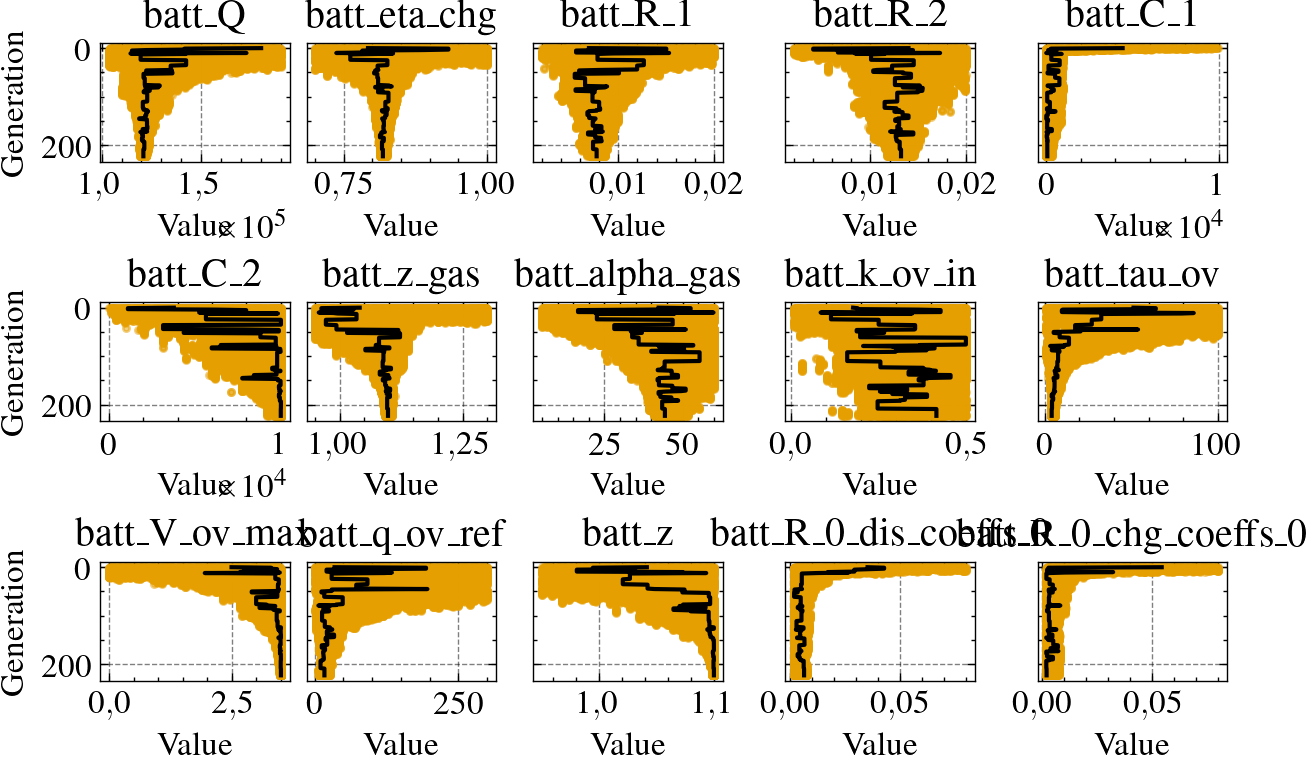

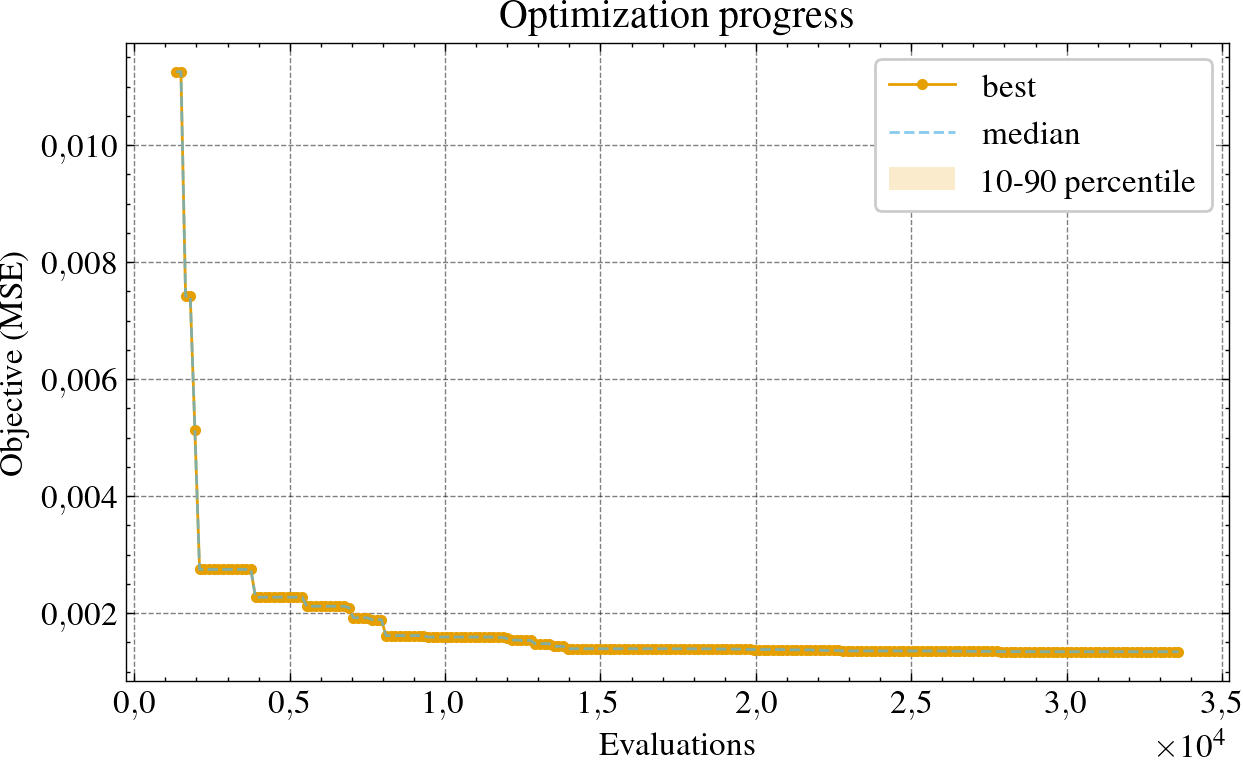

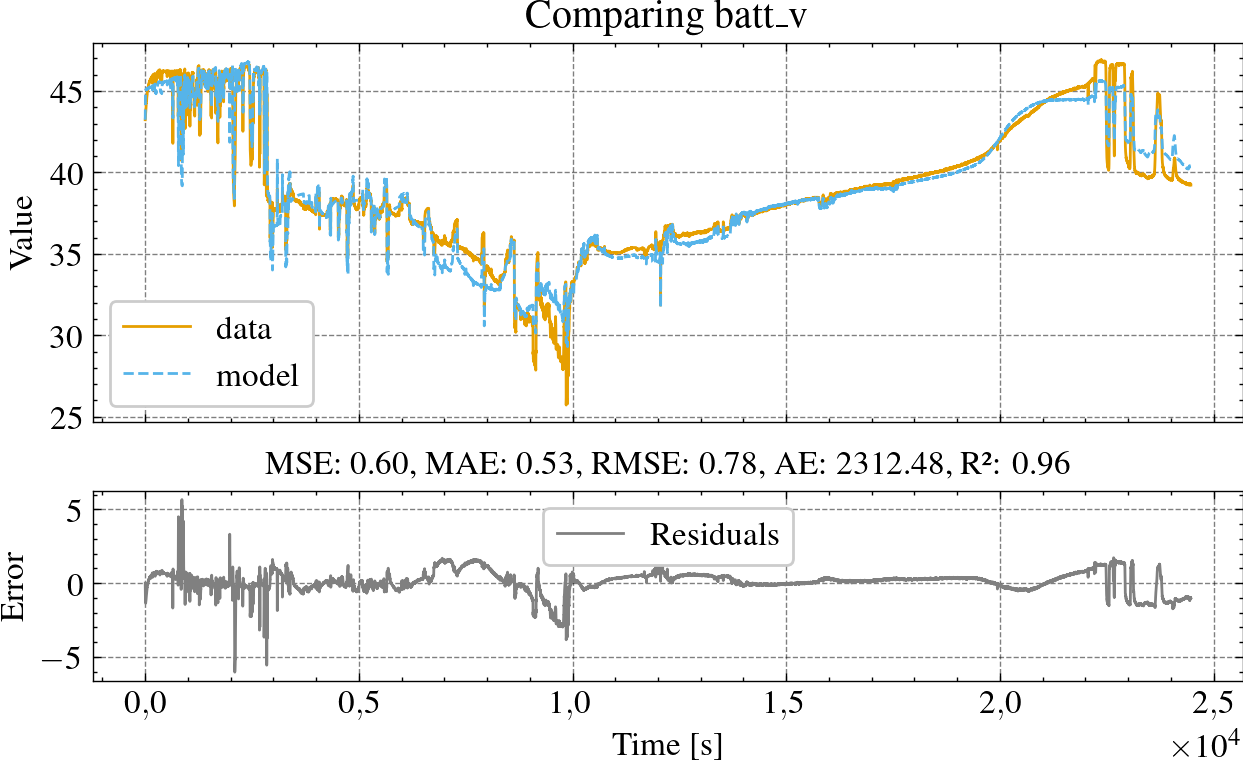

TypeError: check_fit() missing 2 required positional arguments: 'section_name' and 'initial_SOC'

In [12]:
%%time

def build_ECM_constraints(params_bounds: dict, eps = 0.003) -> list[ParamConstraint]:
    names = list(params_bounds.keys())
    idx = {name: i for i, name in enumerate(names)}

    cons: list[ParamConstraint] = []

    # OCV monotonic LUT constraint (monotone increasing in z) ---
    # if 'batt_ocv_coeffs_0' in params_bounds:
    #     ocv_names = sorted( # collect OCV parameters in SoC order
    #         [n for n in names if n.startswith("batt_ocv_coeffs_")],
    #         key=lambda s: int(s.split("_")[-1])
    #     )
    #     for a_name, b_name in zip(ocv_names[:-1], ocv_names[1:]):
    #         cons.append(ParamConstraint(kind="simple_order", idx_a=idx[a_name], idx_b=idx[b_name]))
    #     for i in range(1, len(ocv_names) - 1):
    #         cons.append(ParamConstraint(kind="smoothness", idx_a=idx[ocv_names[i-1]], idx_b=idx[ocv_names[i]], idx_c=idx[ocv_names[i+1]], limit=eps))

    # R0 monotonic LUT constraint (monotone decreasing in z) ---
    if 'batt_R_0_chg_coeffs_0' in params_bounds:
        R0_chg_names = sorted( # collect OCV parameters in SoC order
            [n for n in names if n.startswith("batt_R_0_chg_coeffs_")],
            key=lambda s: int(s.split("_")[-1])
        )
        # for b_name, a_name in zip(R0_chg_names[:-1], R0_chg_names[1:]):
        #     cons.append(ParamConstraint(kind="simple_order", idx_a=idx[a_name], idx_b=idx[b_name]))
        # for i in range(1, len(R0_chg_names) - 1):
        #     cons.append(ParamConstraint(kind="smoothness", idx_a=idx[R0_chg_names[i-1]], idx_b=idx[R0_chg_names[i]], idx_c=idx[R0_chg_names[i+1]], limit=eps))

        cons.append(ParamConstraint(kind="simple_order", idx_a=idx[R0_chg_names[-1]], idx_b=idx['batt_R_1']))  # R0_chg < R1

    if 'batt_R_0_dis_coeffs_0' in params_bounds:
        R0_dis_names = sorted( # collect OCV parameters in SoC order
            [n for n in names if n.startswith("batt_R_0_dis_coeffs_")],
            key=lambda s: int(s.split("_")[-1])
        )
        # for b_name, a_name in zip(R0_dis_names[:-1], R0_dis_names[1:]):
        #     cons.append(ParamConstraint(kind="simple_order", idx_a=idx[a_name], idx_b=idx[b_name]))
        # for i in range(1, len(R0_dis_names) - 1):
        #     cons.append(ParamConstraint(kind="smoothness", idx_a=idx[R0_dis_names[i-1]], idx_b=idx[R0_dis_names[i]], idx_c=idx[R0_dis_names[i+1]], limit=eps))

        cons.append(ParamConstraint(kind="simple_order", idx_a=idx[R0_dis_names[-1]], idx_b=idx['batt_R_1']))  # R0_dis < R1

    cons.append(ParamConstraint(kind="simple_order", idx_a=idx['batt_R_1'], idx_b=idx['batt_R_2']))  # R1 < R2
    cons.append(ParamConstraint(kind="simple_gap", idx_a=idx['batt_C_1'], idx_b=idx['batt_C_2'], gap=10))  # C2 >= 10*C1

    return cons

model_params_D = initial_params.copy()
initial_SOC_D = 1
params_bounds_D = dict(
    # Capacity / SoC scaling
    batt_Q = dict(min=0.60*batt_Q, max=1.10*batt_Q),  # multiplier × nominal_Q [As]
    # batt_eta_dis = dict(min=0.5, max=1.0),
    batt_eta_chg = dict(min=0.7, max=1.0),

    # Dynamic RC behavior
    batt_R_1 = dict(min=0.002,  max=0.020),  # RC1 resistance [Ω]
    batt_R_2 = dict(min=0.002,  max=0.020),  # RC2 resistance [Ω]

    batt_C_1 = dict(min=10.0,   max=10000.0),  # RC1 capacitance [F]
    batt_C_2 = dict(min=10.0,   max=10000.0),  # RC2 capacitance [F]

    # Overcharge / gassing onset (controls right-side bump)
    batt_z_gas     = dict(min=0.95,  max=1.30),   # SoC where gassing begins
    batt_alpha_gas = dict(min=5.0,   max=60.0),   # steepness of gassing onset

    # Overcharge accumulation dynamics
    batt_k_ov_in = dict(min=0.01,   max=0.50),    # fraction of charging current going into q_over
    batt_tau_ov  = dict(min=1.0,    max=100.0),   # q_over relaxation time constant [s]

    # Overcharge → voltage mapping (bump amplitude/shape)
    batt_V_ov_max = dict(min=0.0,  max=3.5),     # max extra voltage per block
    batt_q_ov_ref = dict(min=1.0,  max=300.0),    # q_over saturation shaping

    # Optional: initial condition bounds
    batt_z        = dict(min=0.95,  max=1.10),    # initial SOC
)
lut_coeffs = [
    dict(name='batt_R_0_dis_coeffs', n_coeffs=1, bounds=(0.002, 0.08)),
    dict(name='batt_R_0_chg_coeffs', n_coeffs=1, bounds=(0.002, 0.08)),
]
for coeff in lut_coeffs:
    name = coeff['name']
    coeff_bounds = coeff['bounds']
    n_coeffs = coeff['n_coeffs']
    for i in range(0, n_coeffs):
        params_bounds_D[f'{name}_{i}'] = dict(min=coeff_bounds[0], max=coeff_bounds[1])

# Train w/ normal region
result_D, params_bounds_D, best_params_D, ending_SOC_D = run_battery_optimization(
    model=Battery,
    model_params=model_params_D,
    initial_SOC=initial_SOC_D,
    section_name='Section D',
    df=df,
    params_bounds=params_bounds_D,
    constraint_funcs=build_ECM_constraints(params_bounds_D),
    plot_results=True,
    plot_simulation=True,
    algorithm_pop_size_k=10,
    termination_period=30,
)

check_fit(model_params=model_params_D | best_params_D)



Training on section: Section D
n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |      140 |  0.0177115759 |  4.522279E+04 |             - |             -
     2 |      280 |  0.0177115759 |  2.905034E+04 |             - |             -
     3 |      420 |  0.0055853091 |  1.694811E+04 |             - |             -
     4 |      560 |  0.0055853091 |  8.088828E+03 |             - |             -
     5 |      700 |  0.0055853091 |  3.168529E+03 |             - |             -
     6 |      840 |  0.000000E+00 |  1.007119E+03 |  0.0107233659 |  0.0107233659
     7 |      980 |  0.000000E+00 |  1.398710E+02 |  0.0119319212 |  0.0107233659
     8 |     1120 |  0.000000E+00 |  1.8527271932 |  0.0130441137 |  0.0107233659
     9 |     1260 |  0.000000E+00 |  0.0250258210 |  0.0121370980 |  0.0070786526
    10 |     1400 |  0.000000E+00 |  0.0157061241 |  0.0105516950 |  0.0042448053
    11 |     1540 |  0.000000E+00 |  0.0094689783 |  0.0113031225

{'batt_Q': 172800,
 'batt_eta_chg': 0.8,
 'batt_R_1': 0.01,
 'batt_R_2': 0.01,
 'batt_C_1': 1000.0,
 'batt_C_2': 1000000.0,
 'batt_z_gas': 1,
 'batt_alpha_gas': 20,
 'batt_k_ov_in': 0.1,
 'batt_tau_ov': 5.0,
 'batt_q_ov_ref': 1.5,
 'batt_z': None,
 'batt_R_0_chg_coeffs': None,
 'batt_R_0_dis_coeffs': None}

Best parameters found:


{'batt_Q': 121330.9675546113,
 'batt_eta_chg': 0.8151107937641423,
 'batt_R_1': 0.00757223170548782,
 'batt_R_2': 0.014356419466148386,
 'batt_C_1': 105.38474529529233,
 'batt_C_2': 9963.286899207546,
 'batt_z_gas': 1.0989456179920933,
 'batt_alpha_gas': 47.496788489653326,
 'batt_k_ov_in': 0.44575536904956015,
 'batt_tau_ov': 4.169183294184563,
 'batt_q_ov_ref': 10.298123052145002,
 'batt_z': 1.0999831412941785,
 'batt_R_0_chg_coeffs': [0.0045725603393488535],
 'batt_R_0_dis_coeffs': [0.0034459035615490396]}

Objective value at solution: [0.00155189]


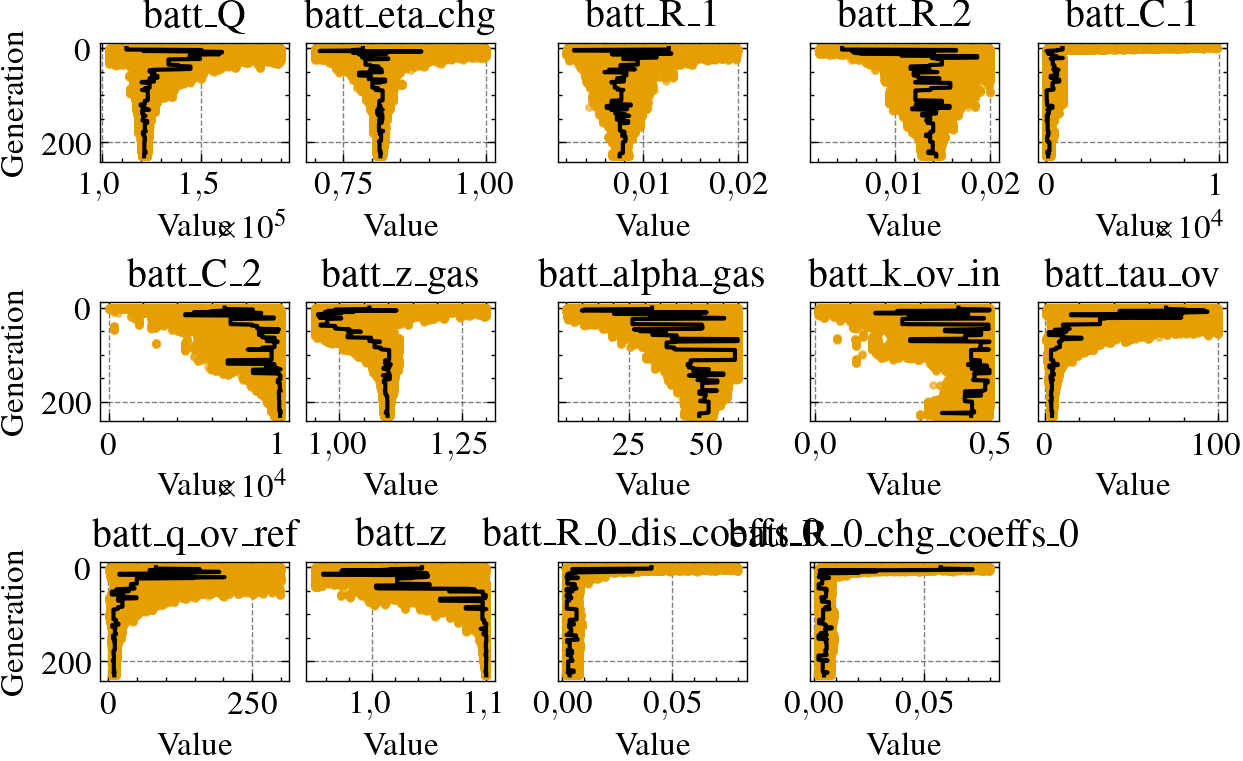

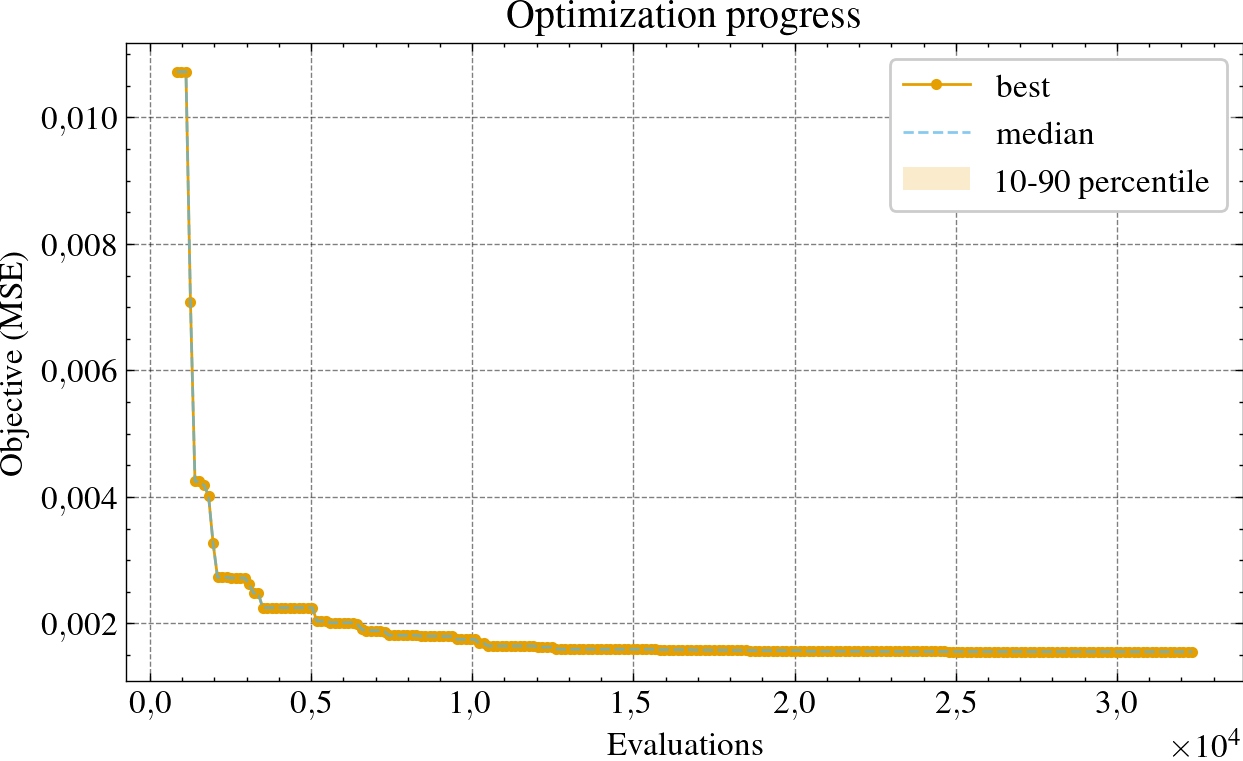

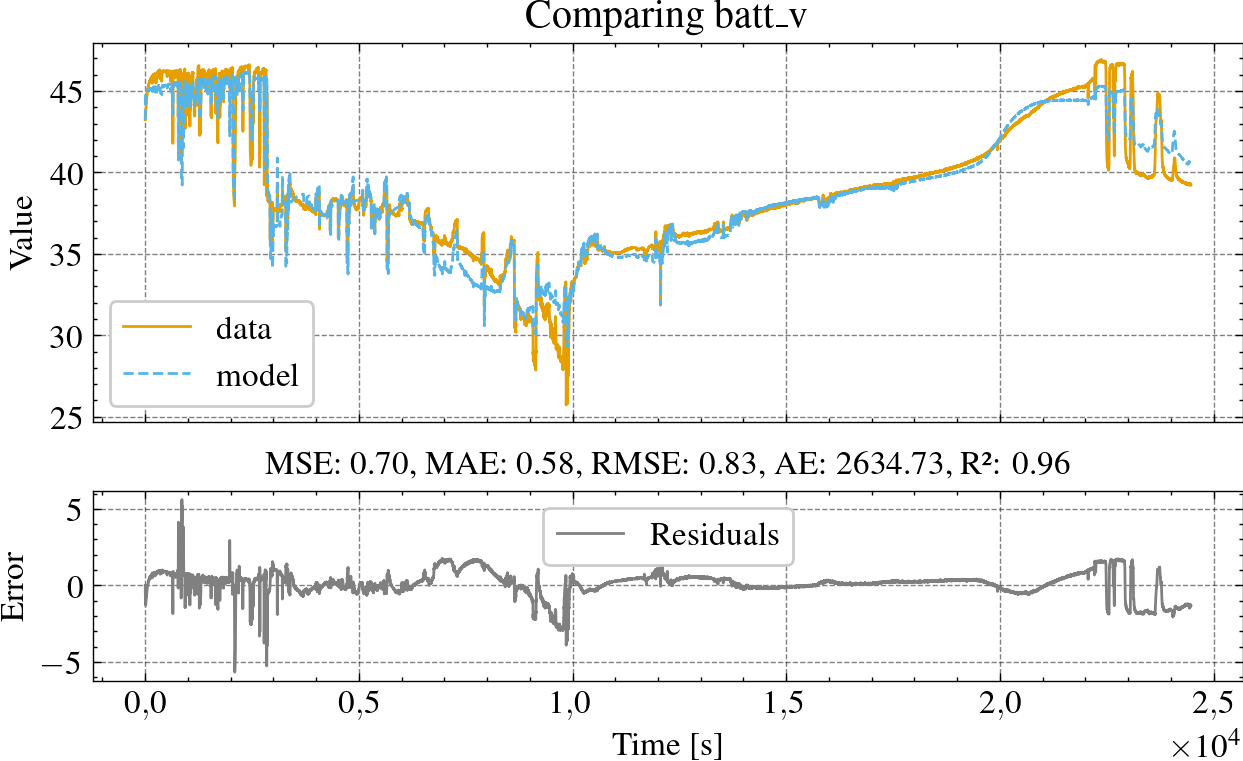

TypeError: check_fit() missing 2 required positional arguments: 'section_name' and 'initial_SOC'

In [13]:
%%time

def build_ECM_constraints(params_bounds: dict, eps = 0.003) -> list[ParamConstraint]:
    names = list(params_bounds.keys())
    idx = {name: i for i, name in enumerate(names)}

    cons: list[ParamConstraint] = []

    # OCV monotonic LUT constraint (monotone increasing in z) ---
    # if 'batt_ocv_coeffs_0' in params_bounds:
    #     ocv_names = sorted( # collect OCV parameters in SoC order
    #         [n for n in names if n.startswith("batt_ocv_coeffs_")],
    #         key=lambda s: int(s.split("_")[-1])
    #     )
    #     for a_name, b_name in zip(ocv_names[:-1], ocv_names[1:]):
    #         cons.append(ParamConstraint(kind="simple_order", idx_a=idx[a_name], idx_b=idx[b_name]))
    #     for i in range(1, len(ocv_names) - 1):
    #         cons.append(ParamConstraint(kind="smoothness", idx_a=idx[ocv_names[i-1]], idx_b=idx[ocv_names[i]], idx_c=idx[ocv_names[i+1]], limit=eps))

    # R0 monotonic LUT constraint (monotone decreasing in z) ---
    if 'batt_R_0_chg_coeffs_0' in params_bounds:
        R0_chg_names = sorted( # collect OCV parameters in SoC order
            [n for n in names if n.startswith("batt_R_0_chg_coeffs_")],
            key=lambda s: int(s.split("_")[-1])
        )
        # for b_name, a_name in zip(R0_chg_names[:-1], R0_chg_names[1:]):
        #     cons.append(ParamConstraint(kind="simple_order", idx_a=idx[a_name], idx_b=idx[b_name]))
        # for i in range(1, len(R0_chg_names) - 1):
        #     cons.append(ParamConstraint(kind="smoothness", idx_a=idx[R0_chg_names[i-1]], idx_b=idx[R0_chg_names[i]], idx_c=idx[R0_chg_names[i+1]], limit=eps))

        cons.append(ParamConstraint(kind="simple_order", idx_a=idx[R0_chg_names[-1]], idx_b=idx['batt_R_1']))  # R0_chg < R1

    if 'batt_R_0_dis_coeffs_0' in params_bounds:
        R0_dis_names = sorted( # collect OCV parameters in SoC order
            [n for n in names if n.startswith("batt_R_0_dis_coeffs_")],
            key=lambda s: int(s.split("_")[-1])
        )
        # for b_name, a_name in zip(R0_dis_names[:-1], R0_dis_names[1:]):
        #     cons.append(ParamConstraint(kind="simple_order", idx_a=idx[a_name], idx_b=idx[b_name]))
        # for i in range(1, len(R0_dis_names) - 1):
        #     cons.append(ParamConstraint(kind="smoothness", idx_a=idx[R0_dis_names[i-1]], idx_b=idx[R0_dis_names[i]], idx_c=idx[R0_dis_names[i+1]], limit=eps))

        cons.append(ParamConstraint(kind="simple_order", idx_a=idx[R0_dis_names[-1]], idx_b=idx['batt_R_1']))  # R0_dis < R1

    cons.append(ParamConstraint(kind="simple_order", idx_a=idx['batt_R_1'], idx_b=idx['batt_R_2']))  # R1 < R2
    cons.append(ParamConstraint(kind="simple_gap", idx_a=idx['batt_C_1'], idx_b=idx['batt_C_2'], gap=10))  # C2 >= 10*C1

    return cons

model_params_D_2 = initial_params.copy()
initial_SOC_D_2 = 1
params_bounds_D_2 = dict(
    # Capacity / SoC scaling
    batt_Q = dict(min=0.60*batt_Q, max=1.10*batt_Q),  # multiplier × nominal_Q [As]
    # batt_eta_dis = dict(min=0.5, max=1.0),
    batt_eta_chg = dict(min=0.7, max=1.0),

    # Dynamic RC behavior
    batt_R_1 = dict(min=0.002,  max=0.020),  # RC1 resistance [Ω]
    batt_R_2 = dict(min=0.002,  max=0.020),  # RC2 resistance [Ω]

    batt_C_1 = dict(min=10.0,   max=10000.0),  # RC1 capacitance [F]
    batt_C_2 = dict(min=10.0,   max=10000.0),  # RC2 capacitance [F]

    # Overcharge / gassing onset (controls right-side bump)
    batt_z_gas     = dict(min=0.95,  max=1.30),   # SoC where gassing begins
    batt_alpha_gas = dict(min=5.0,   max=60.0),   # steepness of gassing onset

    # Overcharge accumulation dynamics
    batt_k_ov_in = dict(min=0.01,   max=0.50),    # fraction of charging current going into q_over
    batt_tau_ov  = dict(min=1.0,    max=100.0),   # q_over relaxation time constant [s]

    # Overcharge → voltage mapping (bump amplitude/shape)
    # batt_V_ov_max = dict(min=0.0,  max=3.5),     # max extra voltage per block
    batt_q_ov_ref = dict(min=1.0,  max=300.0),    # q_over saturation shaping

    # Optional: initial condition bounds
    batt_z        = dict(min=0.95,  max=1.10),    # initial SOC
)
lut_coeffs = [
    dict(name='batt_R_0_dis_coeffs', n_coeffs=1, bounds=(0.002, 0.08)),
    dict(name='batt_R_0_chg_coeffs', n_coeffs=1, bounds=(0.002, 0.08)),
]
for coeff in lut_coeffs:
    name = coeff['name']
    coeff_bounds = coeff['bounds']
    n_coeffs = coeff['n_coeffs']
    for i in range(0, n_coeffs):
        params_bounds_D_2[f'{name}_{i}'] = dict(min=coeff_bounds[0], max=coeff_bounds[1])

# Train w/ normal region
result_D_2, params_bounds_D_2, best_params_D_2, ending_SOC_D_2 = run_battery_optimization(
    model=Battery,
    model_params=model_params_D_2,
    initial_SOC=initial_SOC_D_2,
    section_name='Section D',
    df=df,
    params_bounds=params_bounds_D_2,
    constraint_funcs=build_ECM_constraints(params_bounds_D_2),
    plot_results=True,
    plot_simulation=True,
    algorithm_pop_size_k=10,
    termination_period=30,
)

check_fit(model_params=model_params_D_2 | best_params_D_2)

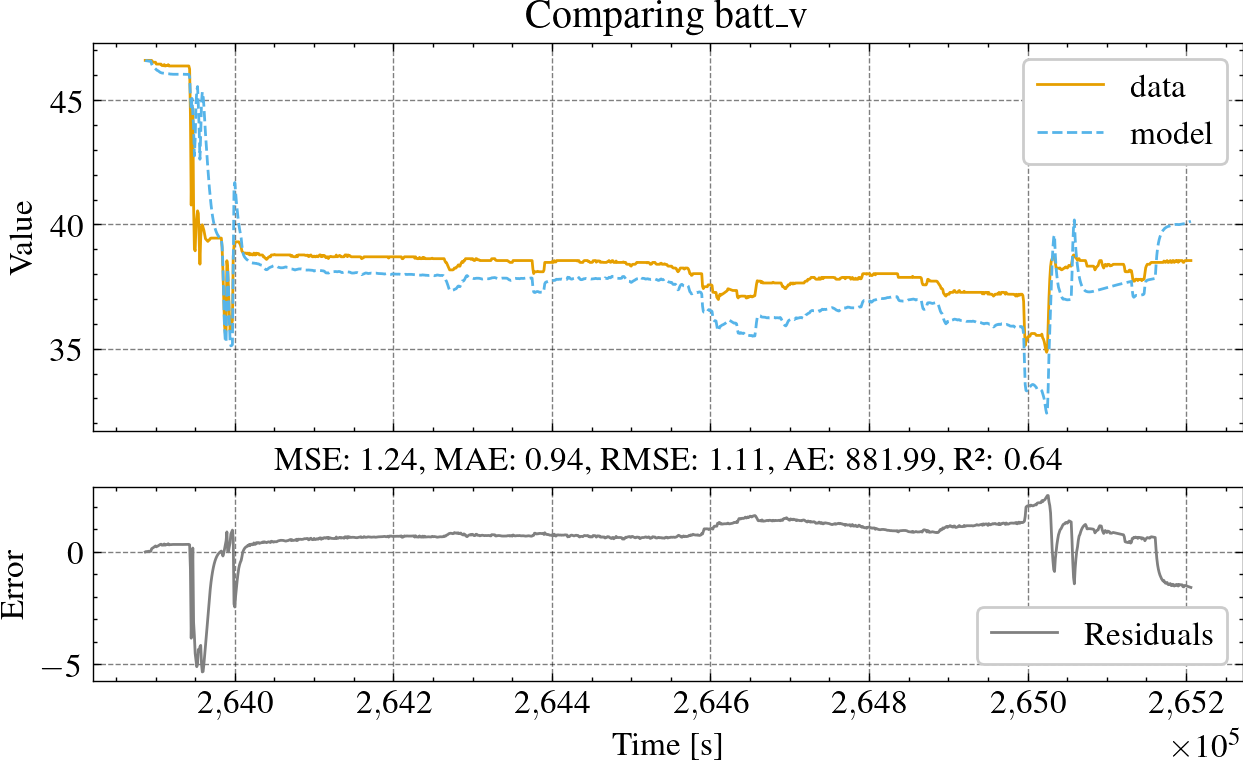

In [41]:
check_fit(section_name='Section E12', initial_SOC=1.30, model_params=model_params_D_2 | best_params_D_2)
